In [1]:
import os
from collections.abc import Callable, Iterable, Iterator, Sequence
from math import ceil, sqrt
from typing import List, Literal, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rootutils
import torch
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import ConcatDataset, Dataset
from torchvision.io import read_image
from tqdm import tqdm
import re
from PIL import Image

root = rootutils.setup_root(search_from=".", indicator=".project-root", pythonpath=True)

from src.data.utils.utils import show_pytorch_images

database_dir = root / "data"

In [119]:
segmentation_data = database_dir / "Fetal-Head-Segmentation"
data = []

In [120]:

def prepare_fetal_planes_data(folder, brain_plane):
    data_path = segmentation_data / folder
    images_path = data_path / "Images"
    segmentations_path = data_path / "SegmentationClass"

    
    images = list(images_path.iterdir())
    for image_path in tqdm(images, desc="Prepare images"):
        
        match = re.search(r'Patient0*(\d+)', image_path.stem)
        patient_num = int(match.group(1)) if match else None
    
        segmentation_path = (segmentations_path / image_path.name)
        segmentation = np.array(Image.open(segmentation_path))
        
        red_color = [255, 0, 0]
        green_color = [0, 255, 0]
        blue_color = [0, 0, 255]
    
        if np.any((segmentation == red_color).all(axis=-1)):
        
            mask = (
                (segmentation == red_color).all(axis=-1) |
                (segmentation == green_color).all(axis=-1) |
                (segmentation == blue_color).all(axis=-1)
            )
            segmentation[mask] = red_color
            
            segmentation = Image.fromarray(segmentation)
            segmentation_path = data_path / "Segmentations" / segmentation_path.name
            segmentation.save(segmentation_path)
        
            data.append({
                "Image_name": image_path.stem,
                "Patient_num": patient_num,
                "Brain_plane": True,
                "Plane": brain_plane,
                "Ultrasound_path": str(image_path.relative_to(segmentation_data)),
                "Segmentation_path": str(segmentation_path.relative_to(segmentation_data))
            })
            # break
        


prepare_fetal_planes_data(
    folder="Trans-cerebellum", 
    brain_plane="Trans-cerebellum",
)
prepare_fetal_planes_data(
    folder="Trans-thalamic", 
    brain_plane="Trans-thalamic",
)
prepare_fetal_planes_data(
    folder="Trans-ventricular", 
    brain_plane="Trans-ventricular",
)
prepare_fetal_planes_data(
    folder="HC18", 
    brain_plane="Other",
)

len(data)

Prepare images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:11<00:00, 13.97it/s]


3792

In [121]:
pd.DataFrame(data)

Image_name  Patient_num  Brain_plane             Plane  \
0     Patient00168_Plane3_3_of_3        168.0         True  Trans-cerebellum   
1     Patient00188_Plane3_3_of_3        188.0         True  Trans-cerebellum   
2     Patient00216_Plane3_4_of_5        216.0         True  Trans-cerebellum   
3     Patient00305_Plane3_4_of_5        305.0         True  Trans-cerebellum   
4     Patient00644_Plane3_2_of_3        644.0         True  Trans-cerebellum   
...                          ...          ...          ...               ...   
3787                      801_HC          NaN         True             Other   
3788                      802_HC          NaN         True             Other   
3789                      803_HC          NaN         True             Other   
3790                      804_HC          NaN         True             Other   
3791                      805_HC          NaN         True             Other   

                                        Ultrasound_path  \
0     Trans-cerebellum/Images/Patient00168_Plane3_3_...   
1     Trans-cerebellum/Images/Patient00188_Plane3_3_...   
2     Trans-cerebellum/Images/Patient00216_Plane3_4_...   
3     Trans-cerebellum/Images/Patient00305_Plane3_4_...   
4     Trans-cerebellum/Images/Patient00644_Plane3_2_...   
...                                                 ...   
3787                             HC18/Images/801_HC.png   
3788                             HC18/Images/802_HC.png   
3789                             HC18/Images/803_HC.png   
3790                             HC18/Images/804_HC.png   
3791                             HC18/Images/805_HC.png   

                                      Segmentation_path  
0     Trans-cerebellum/Segmentations/Patient00168_Pl...  
1     Trans-cerebellum/Segmentations/Patient00188_Pl...  
2     Trans-cerebellum/Segmentations/Patient00216_Pl...  
3     Trans-cerebellum/Segmentations/Patient00305_Pl...  
4     Trans-cerebellum/Segmentations/Patient00644_Pl...  
...                                                 ...  
3787                      HC18/Segmentations/801_HC.png  
3788                      HC18/Segmentations/802_HC.png  
3789                      HC18/Segmentations/803_HC.png  
3790                      HC18/Segmentations/804_HC.png  
3791                      HC18/Segmentations/805_HC.png  

[3792 rows x 6 columns]

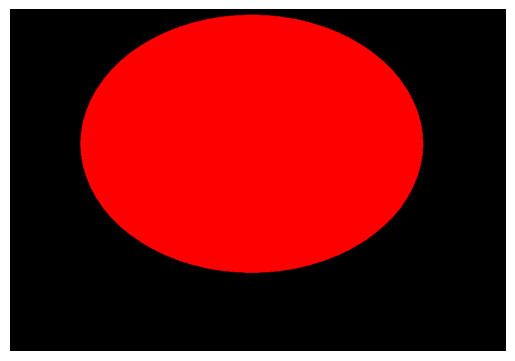

In [89]:
image_path = "/home/zamojskia/ultrasound_fetal_images/data/Fetal-Head-Segmentation/Trans-cerebellum/Segmentations/Patient00644_Plane3_2_of_3.png"
image = np.array(Image.open(image_path))
plt.imshow(image)
plt.axis('off')
plt.show()

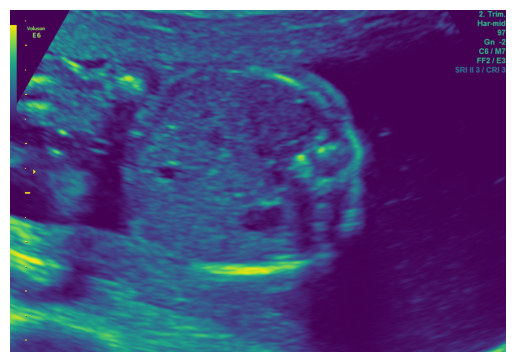

In [92]:
image_path = "/home/zamojskia/ultrasound_fetal_images/data/FETAL_PLANES/Images/Patient01792_Plane2_1_of_1.png"
image = np.array(Image.open(image_path))
plt.imshow(image)
plt.axis('off')
plt.show()

In [94]:
fetal_planes = pd.read_csv(f"{database_dir}/FETAL_PLANES/FETAL_PLANES_DB_data.csv", sep=";")
fetal_planes

Image_name  Patient_num          Plane  \
0      Patient00001_Plane1_1_of_15            1          Other   
1      Patient00001_Plane1_2_of_15            1          Other   
2      Patient00001_Plane1_3_of_15            1          Other   
3      Patient00001_Plane1_4_of_15            1          Other   
4      Patient00001_Plane1_5_of_15            1          Other   
...                            ...          ...            ...   
12395   Patient01791_Plane5_1_of_1         1791    Fetal femur   
12396   Patient01792_Plane2_1_of_1         1792  Fetal abdomen   
12397   Patient01792_Plane3_1_of_1         1792    Fetal brain   
12398   Patient01792_Plane5_1_of_1         1792    Fetal femur   
12399   Patient01792_Plane6_1_of_1         1792   Fetal thorax   

          Brain_plane Operator   US_Machine  Train   
0         Not A Brain    Other        Aloka       1  
1         Not A Brain    Other        Aloka       1  
2         Not A Brain    Other        Aloka       1  
3         Not A Brain    Other        Aloka       1  
4         Not A Brain    Other        Aloka       1  
...               ...      ...          ...     ...  
12395     Not A Brain    Other  Voluson S10       0  
12396     Not A Brain    Other   Voluson E6       0  
12397  Trans-thalamic    Other   Voluson E6       0  
12398     Not A Brain    Other   Voluson E6       0  
12399     Not A Brain    Other   Voluson E6       0  

[12400 rows x 7 columns]

In [135]:
data[0]

{'Image_name': 'Patient00168_Plane3_3_of_3',
 'Patient_num': np.int64(168),
 'Brain_plane': True,
 'Plane': 'Trans-cerebellum',
 'Ultrasound_path': 'Trans-cerebellum/Images/Patient00168_Plane3_3_of_3.png',
 'Segmentation_path': 'Trans-cerebellum/Segmentations/Patient00168_Plane3_3_of_3.png',
 'Train': np.int64(1)}

In [142]:
for v in tqdm(data, desc="Add training value"):
    row = fetal_planes[fetal_planes["Image_name"] == v["Image_name"]]
    if len(row) == 1:
        row = row.iloc[0]
        v["Patient_num"]=str(row["Patient_num"])
        v["Train"]=row["Train "]
    else:
        v["Patient_num"]=None
        v["Train"]=1

pd.DataFrame(data)

Add training value: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13100/13100 [00:12<00:00, 1013.57it/s]


Image_name Patient_num  Brain_plane             Plane  \
0      Patient00168_Plane3_3_of_3         168         True  Trans-cerebellum   
1      Patient00188_Plane3_3_of_3         188         True  Trans-cerebellum   
2      Patient00216_Plane3_4_of_5         216         True  Trans-cerebellum   
3      Patient00305_Plane3_4_of_5         305         True  Trans-cerebellum   
4      Patient00644_Plane3_2_of_3         644         True  Trans-cerebellum   
...                           ...         ...          ...               ...   
13095  Patient01790_Plane1_1_of_1        1790        False             Other   
13096  Patient01791_Plane5_1_of_1        1791        False       Fetal femur   
13097  Patient01792_Plane2_1_of_1        1792        False     Fetal abdomen   
13098  Patient01792_Plane5_1_of_1        1792        False       Fetal femur   
13099  Patient01792_Plane6_1_of_1        1792        False      Fetal thorax   

                                         Ultrasound_path  \
0      Trans-cerebellum/Images/Patient00168_Plane3_3_...   
1      Trans-cerebellum/Images/Patient00188_Plane3_3_...   
2      Trans-cerebellum/Images/Patient00216_Plane3_4_...   
3      Trans-cerebellum/Images/Patient00305_Plane3_4_...   
4      Trans-cerebellum/Images/Patient00644_Plane3_2_...   
...                                                  ...   
13095  FETAL_PLANES/Images/Patient01790_Plane1_1_of_1...   
13096  FETAL_PLANES/Images/Patient01791_Plane5_1_of_1...   
13097  FETAL_PLANES/Images/Patient01792_Plane2_1_of_1...   
13098  FETAL_PLANES/Images/Patient01792_Plane5_1_of_1...   
13099  FETAL_PLANES/Images/Patient01792_Plane6_1_of_1...   

                                       Segmentation_path  Train  
0      Trans-cerebellum/Segmentations/Patient00168_Pl...      1  
1      Trans-cerebellum/Segmentations/Patient00188_Pl...      1  
2      Trans-cerebellum/Segmentations/Patient00216_Pl...      1  
3      Trans-cerebellum/Segmentations/Patient00305_Pl...      1  
4      Trans-cerebellum/Segmentations/Patient00644_Pl...      0  
...                                                  ...    ...  
13095                                               None      0  
13096                                               None      0  
13097                                               None      0  
13098                                               None      0  
13099                                               None      0  

[13100 rows x 7 columns]

In [123]:
images = [row["Image_name"] for row in data]

for _, row in fetal_planes.iterrows():
    if row["Image_name"] not in images and row["Brain_plane"] == "Not A Brain":
        data.append({
            "Image_name": row["Image_name"],
            "Patient_num": row["Patient_num"],
            "Brain_plane": False,
            "Plane": row["Plane"],
            "Ultrasound_path": f"FETAL_PLANES/Images/{row["Image_name"]}.png",
            "Segmentation_path": None,
            "Train": row["Train "]
        })
    # break

len(data)

13100

In [163]:
from sklearn.model_selection import GroupShuffleSplit
from src.data.components.dataset import FetalBrainPlanesDataset


train = FetalBrainPlanesDataset(
    data_dir=database_dir,
    subset="train",
)


train_fetal_planes = fetal_planes[fetal_planes["Train "] == 1].reset_index(drop=True)

splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=5724)
split = splitter.split(train, groups=train.img_labels["Patient_num"])
train_idx, val_idx = next(split)


for v in tqdm(data, desc="Add training value"):
    row = fetal_planes[fetal_planes["Image_name"] == v["Image_name"]]
    if len(row) == 1:
        idx = row.index[0]
        row = row.iloc[0]
        if row["Train "] == 0:
            v["Subset"]= "test"
        elif idx in val_idx:
            v["Subset"]= "val"
        else:
            v["Subset"]= "train"
    else:
        v["Subset"]="train"
    # break

pd.DataFrame(data)

Add training value: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13100/13100 [00:12<00:00, 1016.04it/s]


Image_name Patient_num  Brain_plane             Plane  \
0      Patient00168_Plane3_3_of_3         168         True  Trans-cerebellum   
1      Patient00188_Plane3_3_of_3         188         True  Trans-cerebellum   
2      Patient00216_Plane3_4_of_5         216         True  Trans-cerebellum   
3      Patient00305_Plane3_4_of_5         305         True  Trans-cerebellum   
4      Patient00644_Plane3_2_of_3         644         True  Trans-cerebellum   
...                           ...         ...          ...               ...   
13095  Patient01790_Plane1_1_of_1        1790        False             Other   
13096  Patient01791_Plane5_1_of_1        1791        False       Fetal femur   
13097  Patient01792_Plane2_1_of_1        1792        False     Fetal abdomen   
13098  Patient01792_Plane5_1_of_1        1792        False       Fetal femur   
13099  Patient01792_Plane6_1_of_1        1792        False      Fetal thorax   

                                         Ultrasound_path  \
0      Trans-cerebellum/Images/Patient00168_Plane3_3_...   
1      Trans-cerebellum/Images/Patient00188_Plane3_3_...   
2      Trans-cerebellum/Images/Patient00216_Plane3_4_...   
3      Trans-cerebellum/Images/Patient00305_Plane3_4_...   
4      Trans-cerebellum/Images/Patient00644_Plane3_2_...   
...                                                  ...   
13095  FETAL_PLANES/Images/Patient01790_Plane1_1_of_1...   
13096  FETAL_PLANES/Images/Patient01791_Plane5_1_of_1...   
13097  FETAL_PLANES/Images/Patient01792_Plane2_1_of_1...   
13098  FETAL_PLANES/Images/Patient01792_Plane5_1_of_1...   
13099  FETAL_PLANES/Images/Patient01792_Plane6_1_of_1...   

                                       Segmentation_path  Train Subset  
0      Trans-cerebellum/Segmentations/Patient00168_Pl...      1    val  
1      Trans-cerebellum/Segmentations/Patient00188_Pl...      1  train  
2      Trans-cerebellum/Segmentations/Patient00216_Pl...      1  train  
3      Trans-cerebellum/Segmentations/Patient00305_Pl...      1  train  
4      Trans-cerebellum/Segmentations/Patient00644_Pl...      0   test  
...                                                  ...    ...    ...  
13095                                               None      0   test  
13096                                               None      0   test  
13097                                               None      0   test  
13098                                               None      0   test  
13099                                               None      0   test  

[13100 rows x 8 columns]

(661, 959, 3)


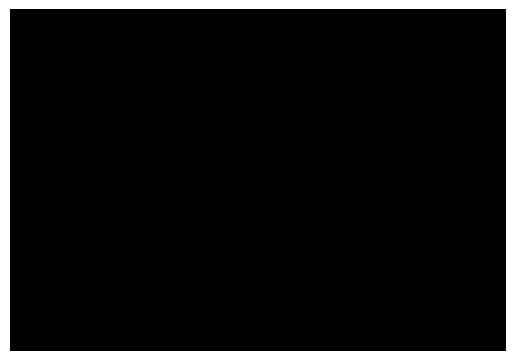

In [117]:
image_path = "/home/zamojskia/ultrasound_fetal_images/data/Fetal-Head-Segmentation/Trans-cerebellum/Segmentations/Patient00644_Plane3_2_of_3.png"
image = np.array(Image.open(image_path))

image[:, :, :] = [0, 0, 0]

print(image.shape)

plt.imshow(image)
plt.axis('off')
plt.show()

image = Image.fromarray(image)
image_path = segmentation_data / "empty-mask.png"
image.save(image_path)

In [164]:
data_df = pd.DataFrame(data)
data_df = data_df.sort_values("Image_name")
data_df.to_csv(segmentation_data / "data.csv", index=False)
data_df

Image_name Patient_num  Brain_plane           Plane  \
2793                       000_HC        None         True           Other   
2794                       001_HC        None         True           Other   
2795                       002_HC        None         True           Other   
2796                       003_HC        None         True           Other   
2797                       004_HC        None         True           Other   
...                           ...         ...          ...             ...   
13096  Patient01791_Plane5_1_of_1        1791        False     Fetal femur   
13097  Patient01792_Plane2_1_of_1        1792        False   Fetal abdomen   
2237   Patient01792_Plane3_1_of_1        1792         True  Trans-thalamic   
13098  Patient01792_Plane5_1_of_1        1792        False     Fetal femur   
13099  Patient01792_Plane6_1_of_1        1792        False    Fetal thorax   

                                         Ultrasound_path  \
2793                              HC18/Images/000_HC.png   
2794                              HC18/Images/001_HC.png   
2795                              HC18/Images/002_HC.png   
2796                              HC18/Images/003_HC.png   
2797                              HC18/Images/004_HC.png   
...                                                  ...   
13096  FETAL_PLANES/Images/Patient01791_Plane5_1_of_1...   
13097  FETAL_PLANES/Images/Patient01792_Plane2_1_of_1...   
2237   Trans-thalamic/Images/Patient01792_Plane3_1_of...   
13098  FETAL_PLANES/Images/Patient01792_Plane5_1_of_1...   
13099  FETAL_PLANES/Images/Patient01792_Plane6_1_of_1...   

                                       Segmentation_path  Train Subset  
2793                       HC18/Segmentations/000_HC.png      1  train  
2794                       HC18/Segmentations/001_HC.png      1  train  
2795                       HC18/Segmentations/002_HC.png      1  train  
2796                       HC18/Segmentations/003_HC.png      1  train  
2797                       HC18/Segmentations/004_HC.png      1  train  
...                                                  ...    ...    ...  
13096                                               None      0   test  
13097                                               None      0   test  
2237   Trans-thalamic/Segmentations/Patient01792_Plan...      0   test  
13098                                               None      0   test  
13099                                               None      0   test  

[13100 rows x 8 columns]

6596
shape
torch.Size([3, 661, 959])
torch.Size([1, 661, 959])
torch.Size([])
values
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor([0, 1], dtype=torch.uint8)
tensor(1, dtype=torch.int32)

shape
torch.Size([1, 165, 240])
torch.Size([1, 165, 240])
torch.Size([])
values
tensor(0.) tensor(0.9490)
tensor([0., 1.])
tensor(1, dtype=torch.int32)
types
torch.float32
torch.int32

shape
torch.Size([1, 165, 240])
torch.Size([1, 165, 240])
torch.Size([])
values
tensor(0.) tensor(1.)
tensor([0.])
tensor(0, dtype=torch.int32)
types
torch.float32
torch.int32


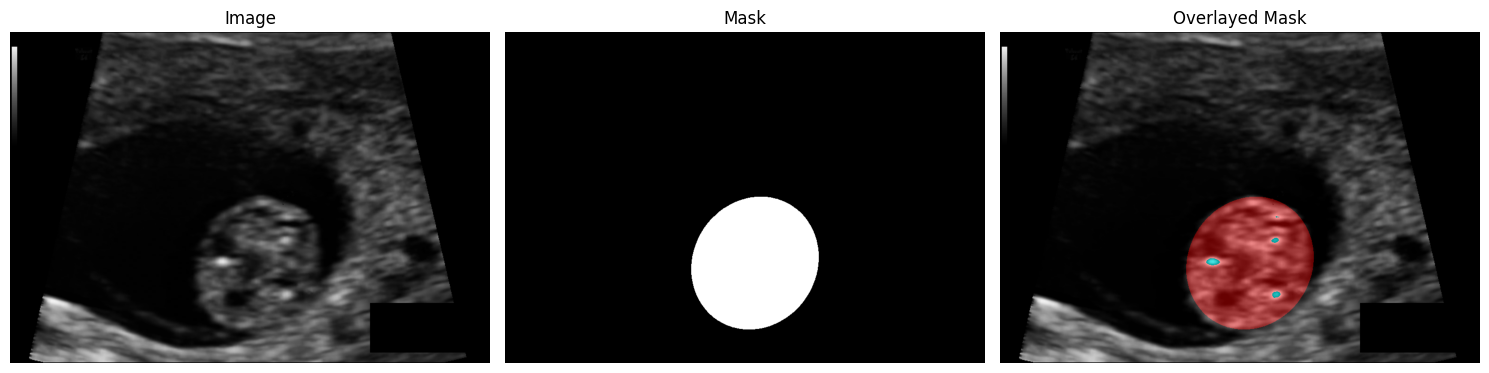

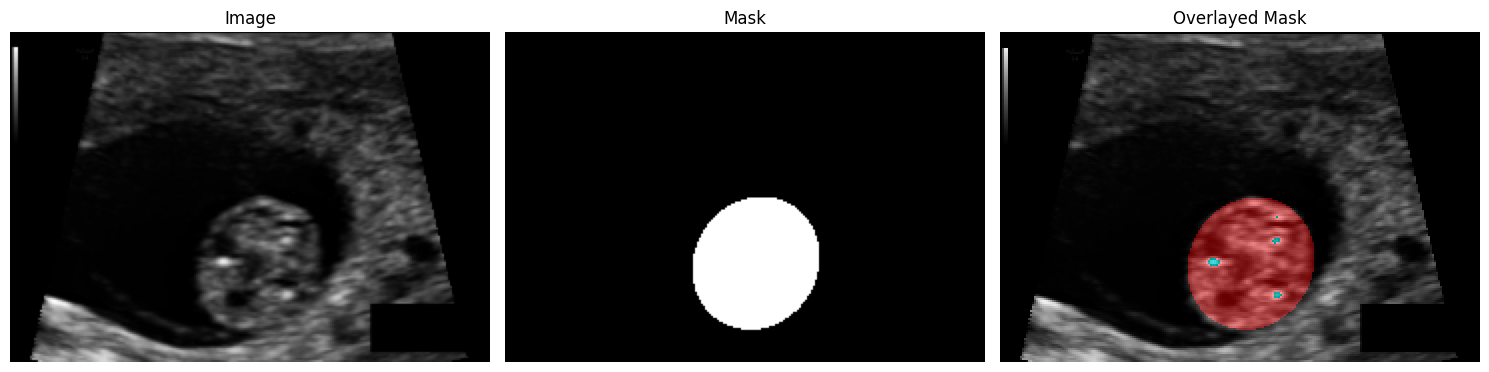

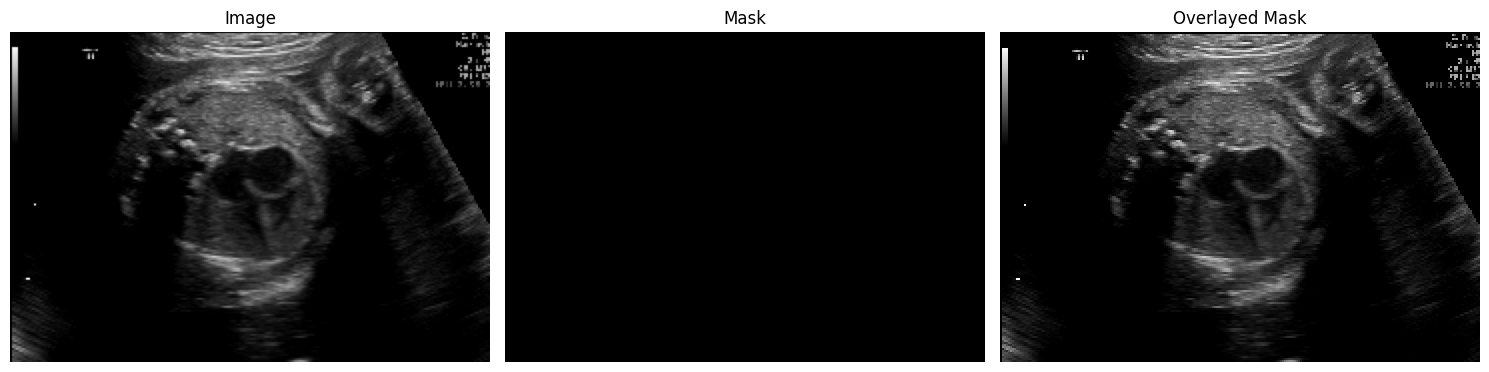

In [90]:
from torchvision.io import read_image
import torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as TF
from torchvision import tv_tensors
from torchvision.transforms import InterpolationMode

class FetalHeadSegmentationDataset(Dataset):
    labels = [
        "Not A Brain",
        "Brain",
    ]

    def __init__(
        self,
        data_dir: str,
        data_name: str = "Fetal-Head-Segmentation",
        subset: Literal["train", "val", "test"] = "train",
        transform: Callable | None = None,
    ):
        self.dataset_dir = f"{data_dir}/{data_name}"
        self.labels = self.load_labels(subset)
        self.transform = transform

    def load_labels(self, subset: str):
        labels = pd.read_csv(f"{self.dataset_dir}/data.csv", dtype={"Patient_num": str})
        labels = labels.where(pd.notnull(labels), None)
        labels = labels[labels["Subset"] == subset]
        return labels.reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if isinstance(idx, tuple):
            idx, sub_idx = idx
            if sub_idx == 0:
                image = self.get_image(idx)
                return self._transform(image)
            elif sub_idx == 1:
                mask = self.get_mask(idx)
                return self._transform(mask)
            elif sub_idx == 2:
                return self.get_label(idx)
        
        image = self.get_image(idx)
        mask = self.get_mask(idx)
        label = self.get_label(idx)
        return *self._transform(image, mask), label

    def get_image(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        img_path = os.path.join(self.dataset_dir, self.labels.Ultrasound_path[idx])
        image = read_image(img_path)
        if image.shape[0] == 4:
            image = image[:3, :, :]

        return tv_tensors.Image(image)

    def get_mask(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        if self.labels.Segmentation_path[idx] is not None:
            img_path = os.path.join(self.dataset_dir, self.labels.Segmentation_path[idx])
            image = read_image(img_path)
            image = image[:1, :, :] # single-channel for mask
            image = image // 255
        else:
            image = self.get_image(idx)
            image = torch.zeros((1, *image.shape[1:]), dtype=torch.uint8)

        return tv_tensors.Mask(image)

    def get_label(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        label = self.labels.Brain_plane[idx]
        label = np.array(label)
        return torch.from_numpy(label).int()

    def _transform(self, *images):
        if self.transform:
            return self.transform(*images)
        return images


input_size = (165, 240)
transform = T.Compose(
    [
        T.Grayscale(),
        # RandomPercentCrop(max_percent=20),
        T.Resize(input_size, interpolation=InterpolationMode.NEAREST),
        # T.AutoAugment(T.AutoAugmentPolicy.IMAGENET),
        # T.RandAugment(magnitude=11),
        # T.TrivialAugmentWide(),
        # T.AugMix(),
        # T.RandomHorizontalFlip(p=0.5),
        # T.RandomVerticalFlip(p=0.5),
        # T.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(1.0, 1.2)),
        T.ToDtype(dtype={tv_tensors.Image: torch.float32, tv_tensors.Mask: torch.float32, "others":None}, scale=True),
        # T.Normalize(mean=[0.17], std=[0.19]),  # FetalBrain
        # T.Normalize(mean=[0.449], std=[0.226]),  # ImageNet
    ]
)

dataset = FetalHeadSegmentationDataset(
    data_dir = database_dir,
    data_name = "Fetal-Head-Segmentation",
    subset = "train",
    transform = None,
)

print(len(dataset))
image, mask, label = dataset[0]
print("shape")
print(image.shape)
print(mask.shape)
print(label.shape)
print("values")
print(image.min(), image.max())
print(torch.unique(mask))
print(label)
print("")

dataset = FetalHeadSegmentationDataset(
    data_dir = database_dir,
    data_name = "Fetal-Head-Segmentation",
    subset = "train",
    transform = transform,
)

image_t, mask_t, label_t = dataset[0]
print("shape")
print(image_t.shape)
print(mask_t.shape)
print(label_t.shape)
print("values")
print(image_t.min(), image_t.max())
print(torch.unique(mask_t))
print(label_t)
print("types")
print(mask_t.dtype)
print(label_t.dtype)
print("")

image_t2, mask_t2, label_t2 = dataset[6595]
print("shape")
print(image_t2.shape)
print(mask_t2.shape)
print(label_t2.shape)
print("values")
print(image_t2.min(), image_t2.max())
print(torch.unique(mask_t2))
print(label_t2)
print("types")
print(mask_t2.dtype)
print(label_t2.dtype)

def display_image(img, ax, title):
    img = img.detach()
    img = TF.to_pil_image(img)
    img = TF.to_grayscale(img)
    ax.imshow(np.asarray(img), cmap="gray")
    ax.set_title(title)
    ax.axis("off")


def overlap_mask(image: torch.Tensor, mask: torch.Tensor, ax, title):
    image = image.clone()
    image = TF.to_grayscale(image)
    if image.shape[0] == 1:
        image = image.repeat(3, 1, 1)
    if image.max() <= 1.0:
        image = image * 255
    image = image.to(torch.uint8)
    
    image[0] = image[0] + mask * 255 * 0.4
    image = torch.clamp(image, min=0, max=255)

    image = TF.to_image(image)
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(title)
    ax.axis("off")
    

def display_image_and_mask(image, mask):
    fig, axes = plt.subplots(ncols=3, nrows=1, squeeze=False, figsize=(15, 4))
    mask = mask.float()
    display_image(image, axes[0, 0], "Image")
    display_image(mask, axes[0, 1], "Mask")
    overlap_mask(image, mask, axes[0, 2], "Overlayed Mask")

    plt.tight_layout()
    plt.show()
 
    return

display_image_and_mask(image, mask)
display_image_and_mask(image_t, mask_t)
display_image_and_mask(image_t2, mask_t2)
# show_pytorch_images([image, mask, image_t, mask_t]).show()

In [319]:
print(len(dataset.labels[dataset.labels["Brain_plane"] == True])) # 2164
print(len(dataset.labels[dataset.labels["Brain_plane"] == False])) # 4432

2164
4432


In [86]:
from collections.abc import Sequence
from typing import Any, Literal

import torch
import torchvision.transforms.v2 as T
from lightning import LightningDataModule
from torch.utils.data import ConcatDataset, DataLoader, Dataset

from src.data.components.dataset import (
    FetalBrainPlanesDataset,
    FetalBrainPlanesSamplesDataset,
    SsimFrameDataset,
    TransformDataset,
)
from src.data.components.transforms import LabelEncoder
from src.data.utils import group_split
from src.data.utils.utils import get_over_sampler, get_under_sampler

class FetalPlanesDataModule(LightningDataModule):
    """A `LightningDataModule` implements 7 key methods:

    ```python
        def prepare_data(self):
        # Things to do on 1 GPU/TPU (not on every GPU/TPU in DDP).
        # Download data, pre-process, split, save to disk, etc...

        def setup(self, stage):
        # Things to do on every process in DDP.
        # Load data, set variables, etc...

        def train_dataloader(self):
        # return train dataloader

        def val_dataloader(self):
        # return validation dataloader

        def test_dataloader(self):
        # return test dataloader

        def predict_dataloader(self):
        # return predict dataloader

        def teardown(self, stage):
        # Called on every process in DDP.
        # Clean up after fit or test.
    ```

    This allows you to share a full dataset without explaining how to download,
    split, transform and process the data.

    Read the docs:
        https://lightning.ai/docs/pytorch/latest/data/datamodule.html
    """

    def __init__(
        self,
        data_dir: str = "data/",
        input_size: tuple[int, int] = (55, 80),
        train_transforms: list = None,
        test_transforms: list = None,
        batch_size: int = 64,
        num_workers: int = 0,
        pin_memory: bool = False,
        sampler: Literal[None, "under", "over"] = None,
        sampler_max_sizes: Sequence[Sequence[int]] = ((-1, -1, -1, -1, 500),),
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        self.dataset = FetalHeadSegmentationDataset

        if train_transforms is not None:
            self.train_transforms = T.Compose(train_transforms)
        else:
            self.train_transforms = T.Compose(
                [
                    T.Grayscale(),
                    # RandomPercentCrop(max_percent=20),
                    T.Resize(input_size, interpolation=InterpolationMode.NEAREST),
                    # T.AutoAugment(T.AutoAugmentPolicy.IMAGENET),
                    # T.RandAugment(magnitude=11),
                    # T.TrivialAugmentWide(),
                    # T.AugMix(),
                    T.RandomHorizontalFlip(p=0.5),
                    T.RandomVerticalFlip(p=0.5),
                    T.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(1.0, 1.2)),
                    T.ToDtype(dtype={tv_tensors.Image: torch.float32, tv_tensors.Mask: torch.float32}, scale=True),
                    # T.Normalize(mean=0.17, std=0.19),  # FetalBrain
                    # T.Normalize(mean=0.449, std=0.226),  # ImageNet
                ]
            )

        if test_transforms is not None:
            self.test_transforms = T.Compose(test_transforms)
        else:
            self.test_transforms = T.Compose(
                [
                    T.Grayscale(),
                    T.Resize(input_size, interpolation=InterpolationMode.NEAREST),
                    T.ToDtype(dtype={tv_tensors.Image: torch.float32, tv_tensors.Mask: torch.float32}, scale=True),
                    # T.Normalize(mean=0.17, std=0.19),  # FetalBrain
                    # T.Normalize(mean=0.449, std=0.226),  # ImageNet
                ]
            )

        self.data_train: Dataset | None = None
        self.data_val: Dataset | None = None
        self.data_test: Dataset | None = None

    @property
    def num_classes(self) -> int:
        """Get the number of classes.
        """
        return 2

    def prepare_data(self) -> None:
        """Download data if needed. Lightning ensures that `self.prepare_data()` is called only
        within a single process on CPU, so you can safely add your downloading logic within. In
        case of multi-node training, the execution of this hook depends upon
        `self.prepare_data_per_node()`.

        Do not use it to assign state (self.x = y).
        """
        pass

    def setup(self, stage: str | None = None) -> None:
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.

        This method is called by Lightning before `trainer.fit()`, `trainer.validate()`, `trainer.test()`, and
        `trainer.predict()`, so be careful not to execute things like random split twice! Also, it is called after
        `self.prepare_data()` and there is a barrier in between which ensures that all the processes proceed to
        `self.setup()` once the data is prepared and available for use.

        :param stage: The stage to setup. Either `"fit"`, `"validate"`, `"test"`, or `"predict"`. Defaults to ``None``.
        """
        # load and split datasets only if not loaded already
        if not self.data_train and not self.data_val and not self.data_test:
            self.data_train = self.dataset(
                data_dir = self.hparams.data_dir,
                subset = "train",
                transform = self.train_transforms,
            )
            self.data_val = self.dataset(
                data_dir = self.hparams.data_dir,
                subset = "val",
                transform = self.test_transforms,
            )
            self.data_test = self.dataset(
                data_dir = self.hparams.data_dir,
                subset = "test",
                transform = self.test_transforms,
            )

    def train_dataloader(self) -> DataLoader[Any]:
        """Create and return the train dataloader.

        :return: The train dataloader.
        """
        if self.hparams.sampler == "under":
            return DataLoader(
                dataset=self.data_train,
                batch_size=self.hparams.batch_size,
                num_workers=self.hparams.num_workers,
                pin_memory=False,
                sampler=get_under_sampler(
                    datasets=[self.data_train],
                    labels=torch.arange(self.num_classes),
                    max_sizes=self.hparams.sampler_max_sizes,
                ),
            )
        elif self.hparams.sampler == "over":
            return DataLoader(
                dataset=self.data_train,
                batch_size=self.hparams.batch_size,
                num_workers=self.hparams.num_workers,
                pin_memory=self.hparams.pin_memory,
                sampler=get_over_sampler(self.data_train),
            )
        else:
            return DataLoader(
                dataset=self.data_train,
                batch_size=self.hparams.batch_size,
                num_workers=self.hparams.num_workers,
                pin_memory=self.hparams.pin_memory,
                shuffle=True,
            )

    def val_dataloader(self) -> DataLoader[Any]:
        """Create and return the validation dataloader.

        :return: The validation dataloader.
        """
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size * 2,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self) -> DataLoader[Any]:
        """Create and return the test dataloader.

        :return: The test dataloader.
        """
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size * 3,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def teardown(self, stage: str | None = None) -> None:
        """Lightning hook for cleaning up after `trainer.fit()`, `trainer.validate()`,
        `trainer.test()`, and `trainer.predict()`.

        :param stage: The stage being torn down. Either `"fit"`, `"validate"`, `"test"`, or `"predict"`.
            Defaults to ``None``.
        """
        pass

    def state_dict(self) -> dict[Any, Any]:
        """Called when saving a checkpoint. Implement to generate and save the datamodule state.

        :return: A dictionary containing the datamodule state that you want to save.
        """
        return {}

    def load_state_dict(self, state_dict: dict[str, Any]) -> None:
        """Called when loading a checkpoint. Implement to reload datamodule state given datamodule
        `state_dict()`.

        :param state_dict: The datamodule state returned by `self.state_dict()`.
        """
        pass

data_module = FetalPlanesDataModule(
    data_dir = database_dir,
    input_size = (165, 240),
    batch_size = 64,
    num_workers = 8,
    pin_memory = True,
)
data_module.setup()

In [87]:
import itertools
from collections.abc import Callable
from typing import Any

import torch
from lightning import LightningModule
from torch import Tensor
from torchmetrics import Accuracy, ConfusionMatrix, F1Score, MaxMetric, MeanMetric

from src.data.components.transforms import Affine, HorizontalFlip, VerticalFlip
from src.models.components.utils import get_model
from src.models.utils.wandb import wandb_confusion_matrix
from src.utils.plots import log_to_wandb
import segmentation_models_pytorch as smp


class FetalHeadSegmentationLitModule(LightningModule):
    """A `LightningModule` implements 8 key methods:

    ```python
    def __init__(self):
    # Define initialization code here.

    def setup(self, stage):
    # Things to setup before each stage, 'fit', 'validate', 'test', 'predict'.
    # This hook is called on every process when using DDP.

    def training_step(self, batch, batch_idx):
    # The complete training step.

    def validation_step(self, batch, batch_idx):
    # The complete validation step.

    def test_step(self, batch, batch_idx):
    # The complete test step.

    def predict_step(self, batch, batch_idx):
    # The complete predict step.

    def configure_optimizers(self):
    # Define and configure optimizers and LR schedulers.
    ```

    Docs:
        https://lightning.ai/docs/pytorch/latest/common/lightning_module.html
    """

    def __init__(
        self,
        criterion: torch.nn.Module,
        lr: float,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        self.model = smp.Unet(encoder_name="mobilenet_v2", encoder_weights="imagenet", in_channels=1, classes=1, activation=None)

        # loss function
        self.criterion_fn = criterion()

        # metric
        self.train_loss = MeanMetric()
        self.train_label_f1 = F1Score(task="binary")
        self.train_label_acc = Accuracy(task="binary")
        self.train_pixel_f1 = F1Score(task="binary")
        self.train_pixel_acc = Accuracy(task="binary")
        
        self.val_loss = MeanMetric()
        self.val_label_f1 = F1Score(task="binary")
        self.val_label_f1_best = MaxMetric()
        self.val_label_acc = Accuracy(task="binary")
        self.val_label_acc_best = MaxMetric()
        self.val_pixel_f1 = F1Score(task="binary")
        self.val_pixel_f1_best = MaxMetric()
        self.val_pixel_acc = Accuracy(task="binary")
        self.val_pixel_acc_best = MaxMetric()
        
        self.test_loss = MeanMetric()
        self.test_label_f1 = F1Score(task="binary")
        self.test_label_acc = Accuracy(task="binary")
        self.test_label_cm = ConfusionMatrix(task="binary", normalize="none")
        self.test_pixel_f1 = F1Score(task="binary")
        self.test_pixel_acc = Accuracy(task="binary")

    def on_train_start(self) -> None:
        """Lightning hook that is called when training begins."""
        # by default lightning executes validation step sanity checks before training starts,
        # so we need to make sure val_f1_best doesn't store accuracy from these checks
        self.val_label_f1_best.reset()
        self.val_label_acc_best.reset()
        self.val_pixel_f1_best.reset()
        self.val_pixel_acc_best.reset()

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def model_step(self, batch: tuple[Tensor, Tensor, Tensor]) -> tuple[Tensor, Tensor, Tensor, Tensor]:
        images, masks, labels = batch
        logits = self.forward(images)
        loss = self.criterion_fn(logits, masks)

        # calculate prediction label
        prediction_mask = torch.sigmoid(logits)                   # [B, 1, H, W], values 0-1
        binary_mask = (prediction_mask > 0.5).int()               # [B, 1, H, W], values 0 or 1
        binary_mask = binary_mask.squeeze(1)                      # [B, H, W]
        total_pixels = binary_mask[0].numel()                     # H * W
        ones_counts = binary_mask.sum(dim=(1, 2))                 # [B]
        ones_percent = ones_counts.float() / total_pixels # [B]
        prediction_label = (ones_percent >= 0.05).int()           # [B], 1 if >=5% ones, else 0
        
        return loss, logits, prediction_mask, masks, prediction_label, labels

    def training_step(self, batch: tuple[Tensor, Tensor, Tensor], batch_idx: int) -> dict:
        """Perform a single training step on a batch of data from the training set.

        :param batch: A batch of data (a tuple) containing the input tensor of images and target
            labels.
        :param batch_idx: The index of the current batch.
        """
        loss, logits, prediction_mask, masks, prediction_label, labels = self.model_step(batch)

        # update and log metrics
        self.train_loss(loss, weight=logits.shape[0])
        self.train_label_f1(prediction_label, labels)
        self.train_label_acc(prediction_label, labels)
        self.train_pixel_f1(prediction_mask, masks)
        self.train_pixel_acc(prediction_mask, masks)
        self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/label/f1", self.train_label_f1, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/label/acc", self.train_label_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/pixel/f1", self.train_pixel_f1, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/pixel/acc", self.train_pixel_acc, on_step=False, on_epoch=True, prog_bar=True)

        # remember to always return loss from `training_step()` or backpropagation will fail!
        return loss

    def on_train_epoch_end(self) -> None:
        """Lightning hook that is called when a training epoch ends."""
        pass

    def on_validation_start(self) -> None:
        """Lightning hook that is called when a validation epoch ends."""
        pass

    def validation_step(self, batch: tuple[Tensor, Tensor, Tensor], batch_idx: int, dataloader_idx: int = 0) -> dict:
        """Perform a single validation step on a batch of data from the validation set.

        :param batch: A batch of data (a tuple) containing the input tensor of images and target
            labels.
        :param batch_idx: The index of the current batch.
        :param dataloader_idx: The index of the current dataloader.
        """
        loss, logits, prediction_mask, masks, prediction_label, labels = self.model_step(batch)

        # update and log metrics
        self.val_loss(loss, weight=logits.shape[0])
        self.val_label_f1(prediction_label, labels)
        self.val_label_acc(prediction_label, labels)
        self.val_pixel_f1(prediction_mask, masks)
        self.val_pixel_acc(prediction_mask, masks)
        self.log("val/loss", self.val_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/label/f1", self.val_label_f1, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/label/acc", self.val_label_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/pixel/f1", self.val_pixel_f1, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/pixel/acc", self.val_pixel_acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_validation_epoch_end(self) -> None:
        """Lightning hook that is called when a validation epoch ends."""
        self.val_label_f1_best(self.val_label_f1.compute())
        self.val_label_acc_best(self.val_label_acc.compute())
        self.val_pixel_f1_best(self.val_pixel_f1.compute())
        self.val_pixel_acc_best(self.val_pixel_acc.compute())

        # log a value through `.compute()` method, instead of as a metric object
        # otherwise metric would be reset by lightning after each epoch
        self.log("val/label/f1_best", self.val_label_f1_best.compute(), sync_dist=True, prog_bar=True)
        self.log("val/label/acc_best", self.val_label_acc_best.compute(), sync_dist=True, prog_bar=True)
        self.log("val/pixel/f1_best", self.val_pixel_f1_best.compute(), sync_dist=True, prog_bar=True)
        self.log("val/pixel/acc_best", self.val_pixel_acc_best.compute(), sync_dist=True, prog_bar=True)

    def on_test_start(self) -> None:
        """Lightning hook that is called when testing begins."""
        self.test_label_cm.reset()

    def test_step(self, batch: tuple[Tensor, Tensor, Tensor], batch_idx: int) -> dict:
        """Perform a single test step on a batch of data from the test set.

        :param batch: A batch of data (a tuple) containing the input tensor of images and target
            labels.
        :param batch_idx: The index of the current batch.
        """
        loss, logits, prediction_mask, masks, prediction_label, labels = self.model_step(batch)

        # update and log metrics
        self.test_loss(loss, weight=logits.shape[0])
        self.test_label_f1(prediction_label, labels)
        self.test_label_acc(prediction_label, labels)
        self.test_label_cm.update(prediction_label, labels)
        self.test_pixel_f1(prediction_mask, masks)
        self.test_pixel_acc(prediction_mask, masks)
        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/label/f1", self.test_label_f1, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/label/acc", self.test_label_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/pixel/f1", self.test_pixel_f1, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/pixel/acc", self.test_pixel_acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_test_epoch_end(self) -> None:
        """Lightning hook that is called when a test epoch ends."""
        self.log_confusion_matrix("test/pixel/conf", self.test_label_cm.compute())

    def log_confusion_matrix(self, name: str, confusion_matrix: Tensor, title: str | None = None):
        log_to_wandb(
            lambda: {
                name: wandb_confusion_matrix(
                    cm=confusion_matrix,
                    class_names=FetalHeadSegmentationDataset.labels,
                    title=title,
                )
            },
            loggers=self.loggers,
        )

    def configure_optimizers(self) -> dict[str, Any]:
        """Configures optimizers and learning-rate schedulers to be used for training.

        Normally you'd need one, but in the case of GANs or similar you might need multiple.

        Examples:
            https://lightning.ai/docs/pytorch/latest/common/lightning_module.html#configure-optimizers

        :return: A dict containing the configured optimizers and learning-rate schedulers to be used for training.
        """
        optimizer = torch.optim.Adam(
            params=filter(lambda p: p.requires_grad, self.model.parameters()), 
            lr=self.hparams.lr,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.1, patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val/loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }


class DiceLoss(torch.nn.Module):
    def forward(self, inputs, targets, smooth=1.0):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice


class DiceBCELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss()
        self.bce = torch.nn.BCEWithLogitsLoss()
    
    def forward(self, inputs, targets):
        return self.dice(inputs, targets) + self.bce(inputs, targets)


lit_module = FetalHeadSegmentationLitModule(
    criterion=DiceBCELoss,
    lr=1e-3,
)

In [88]:
import lightning as pl

trainer = pl.Trainer(
    accelerator="gpu",
    devices="1",
    min_epochs=1,
    max_epochs=10,
    deterministic=False,
)

# Start training
trainer.fit(model=lit_module, datamodule=data_module)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type                  | Params | Mode 
----------------------------------------------------------------------
0  | model              | Unet                  | 6.6 M  | train
1  | criterion_fn       | DiceBCELoss           | 0      | train
2  | train_loss         | MeanMetric            | 0      | train
3  | train_label_f1     | BinaryF1Score         | 0      | train
4  | train_label_acc    | BinaryAccuracy        | 0      | train
5  | train_pixel_f1     | BinaryF1Score         | 0      | train
6  | train_pixel_acc    | BinaryAccuracy        | 0      | train
7  | val_loss           | MeanMetric         

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [89]:
trainer.test(model=lit_module, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/label/acc       │    0.9918224215507507     │
│       test/label/f1       │    0.9844903945922852     │
│         test/loss         │    0.09999948740005493    │
│      test/pixel/acc       │    0.9939048290252686     │
│       test/pixel/f1       │    0.9638420343399048     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.09999948740005493,
  'test/label/f1': 0.9844903945922852,
  'test/label/acc': 0.9918224215507507,
  'test/pixel/f1': 0.9638420343399048,
  'test/pixel/acc': 0.9939048290252686}]

In [57]:
data_module.data_test.labels[data_module.data_test.labels["Brain_plane"] == True].index

Index([ 303,  305,  306,  309,  311,  324,  326,  331,  332,  333,
       ...
       5115, 5119, 5120, 5121, 5126, 5127, 5128, 5129, 5130, 5133],
      dtype='int64', length=1337)

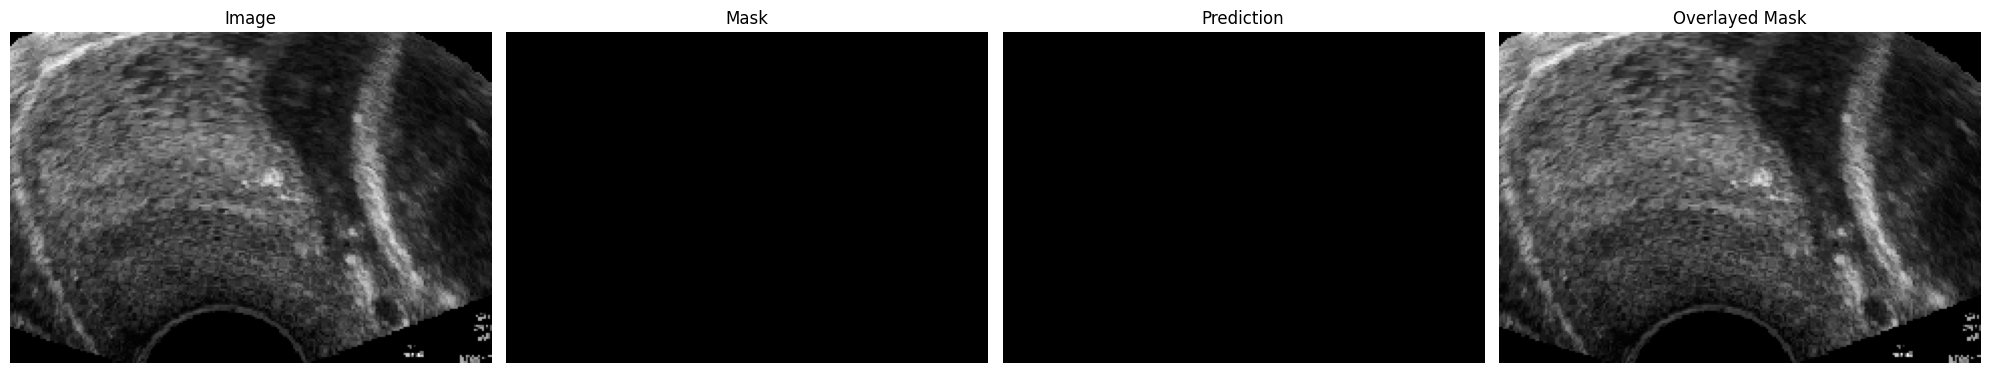

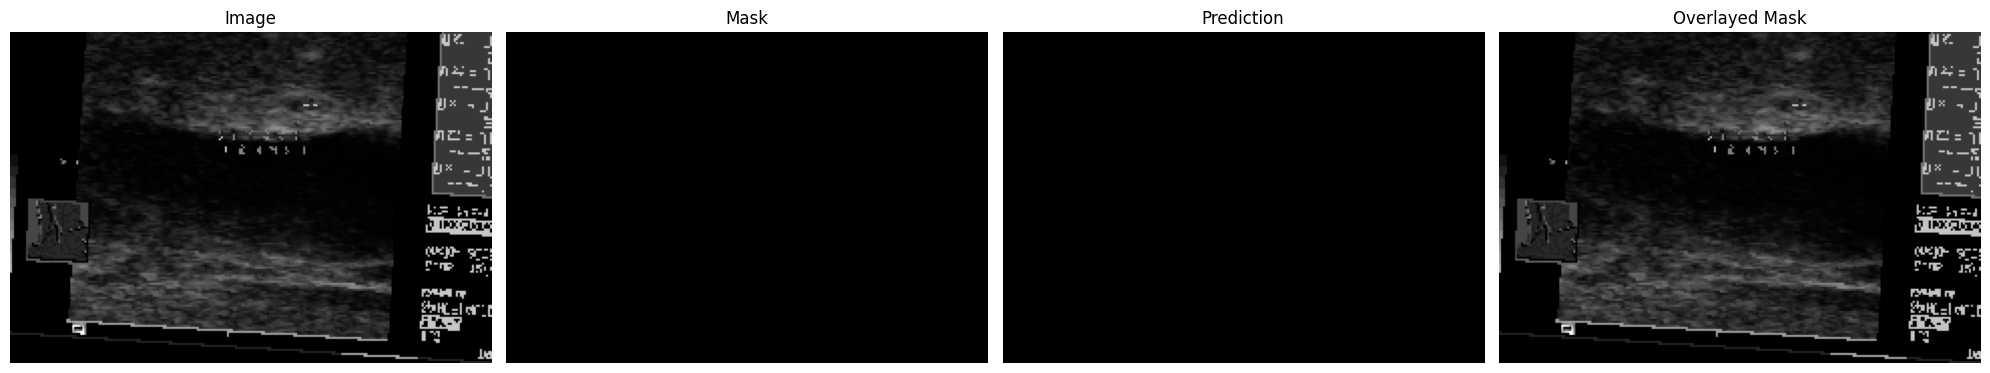

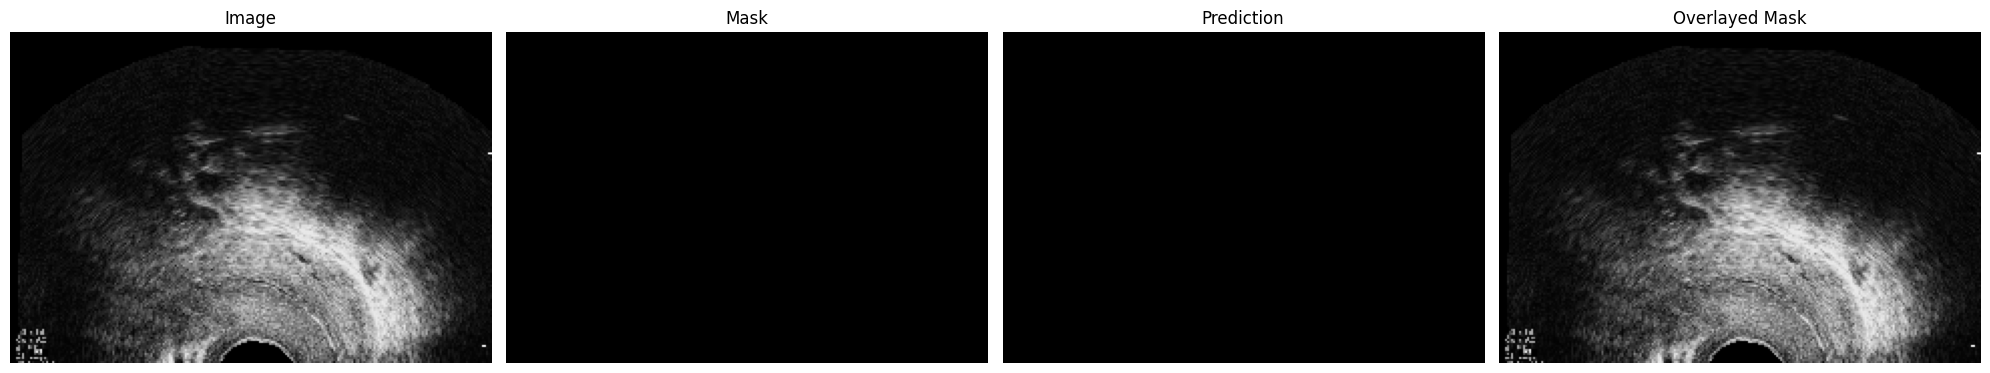

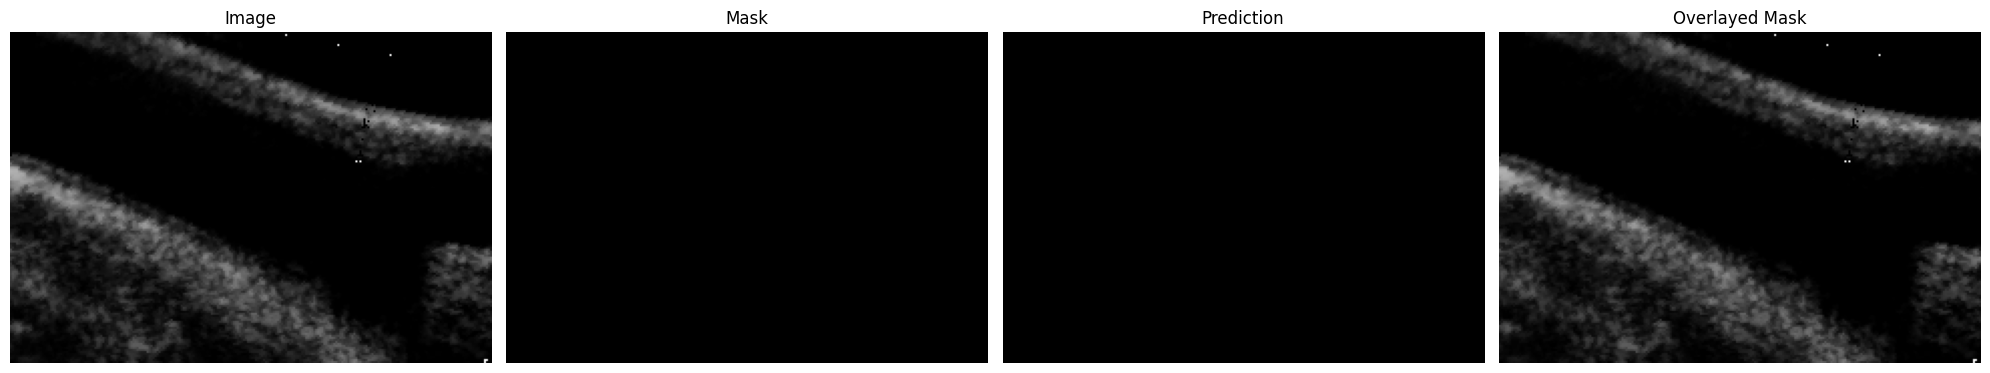

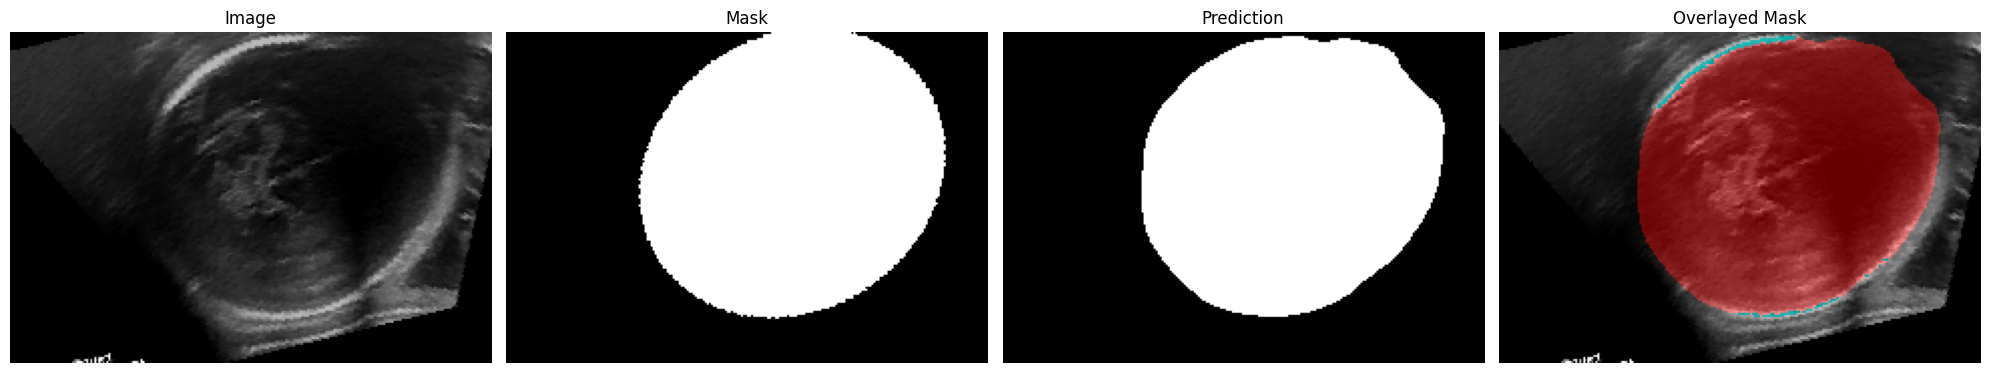

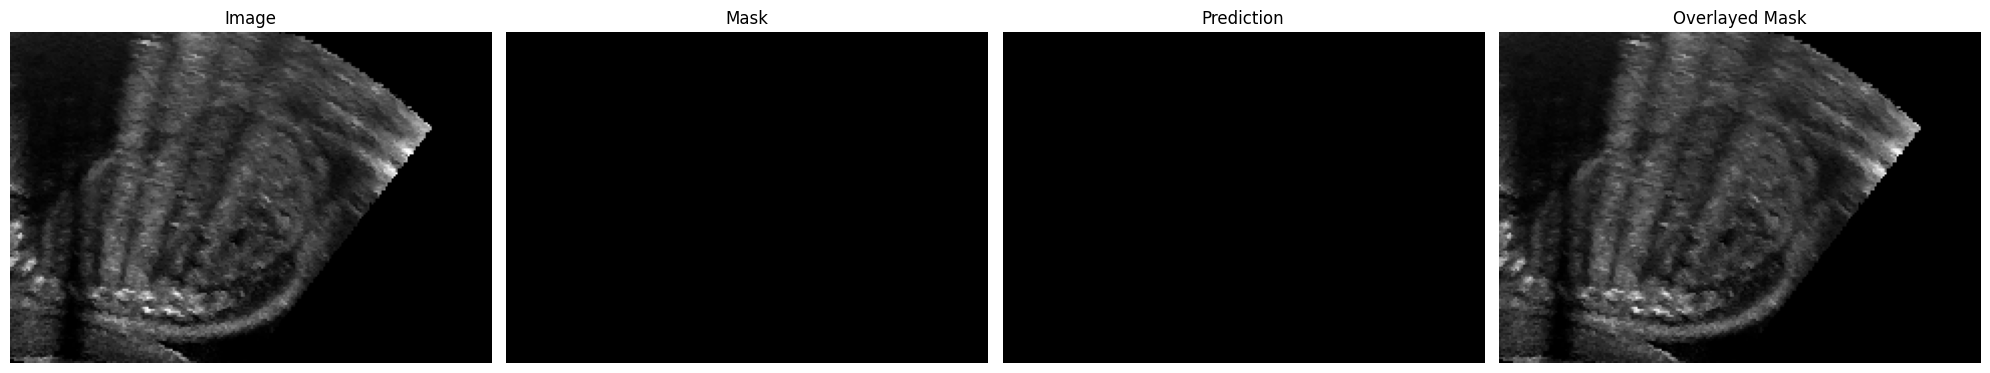

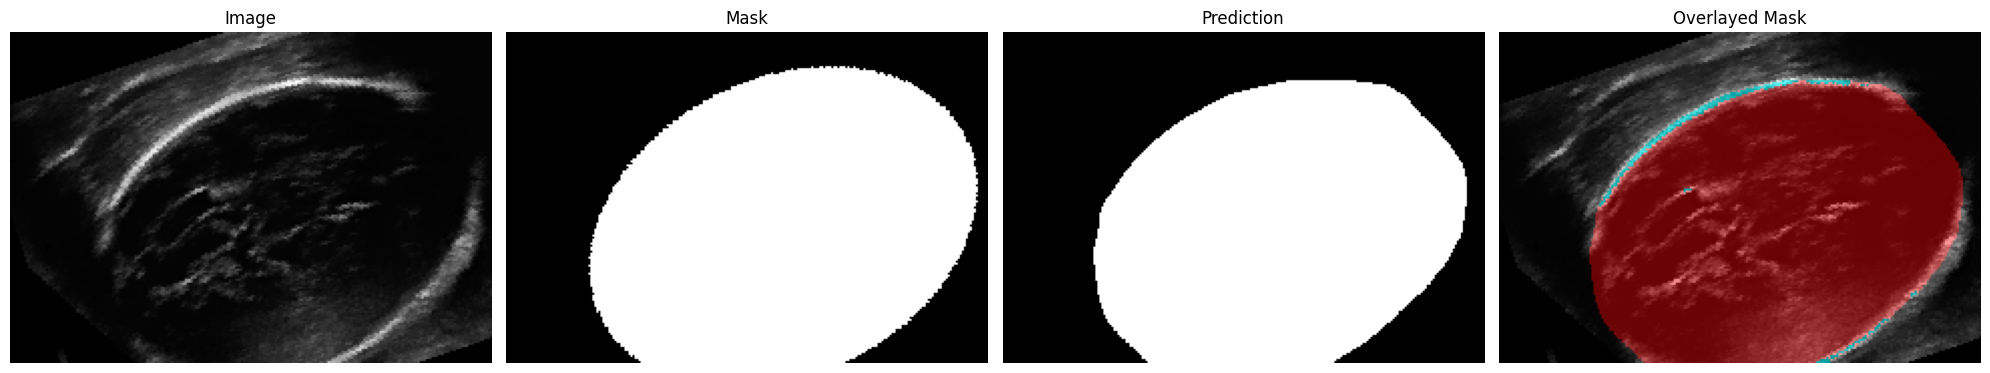

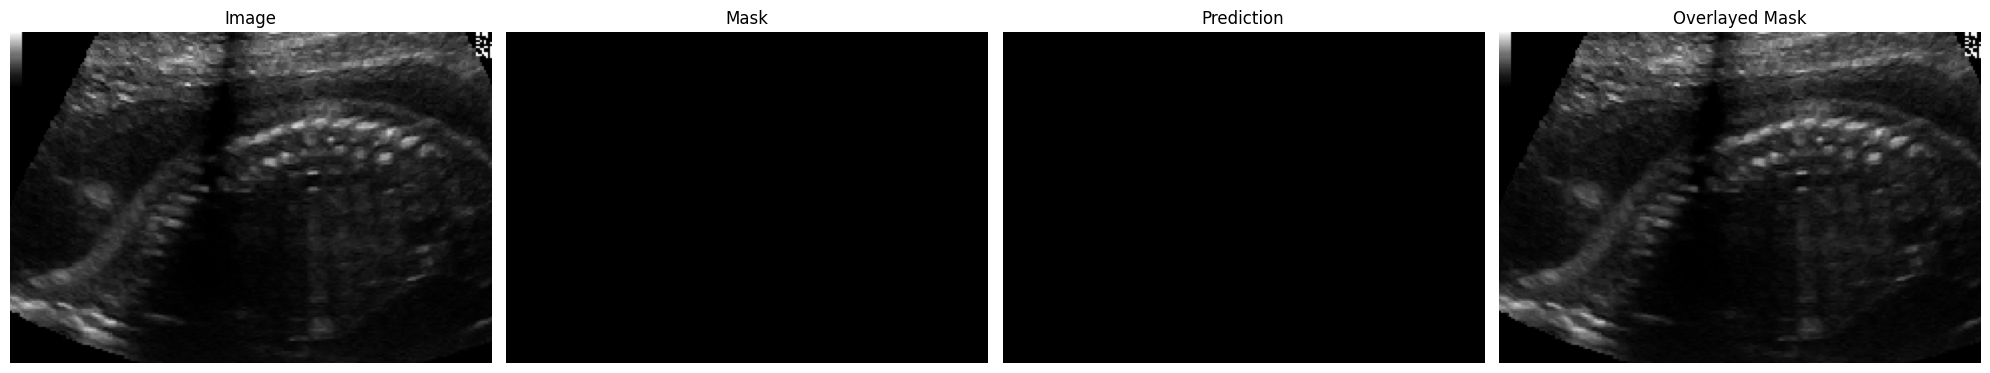

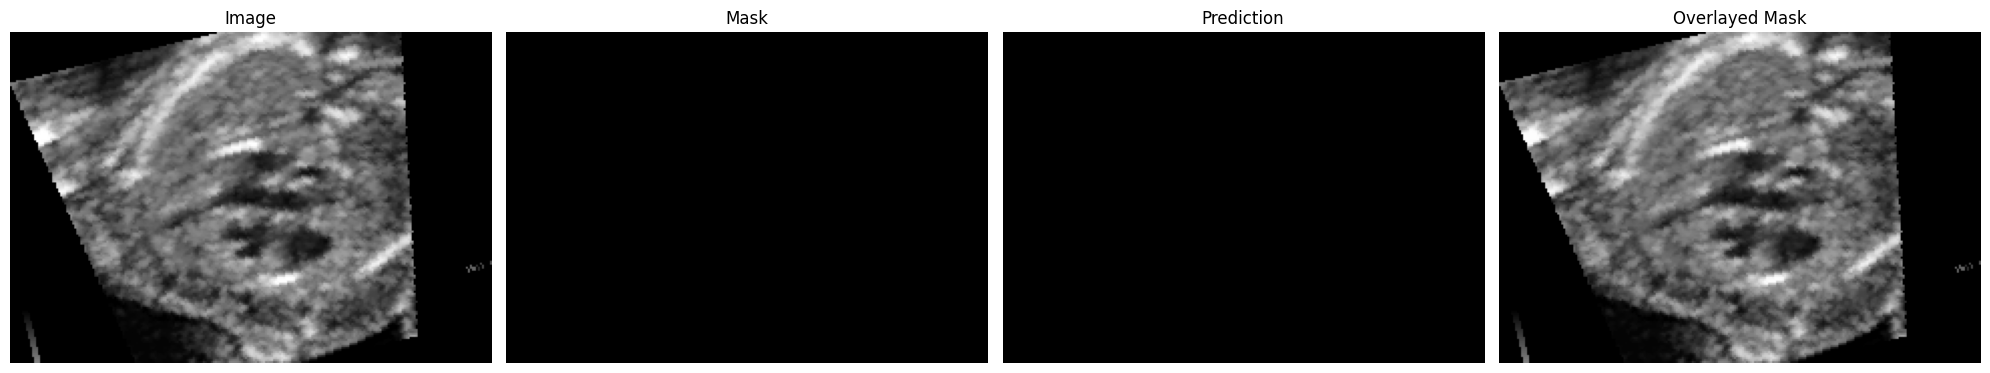

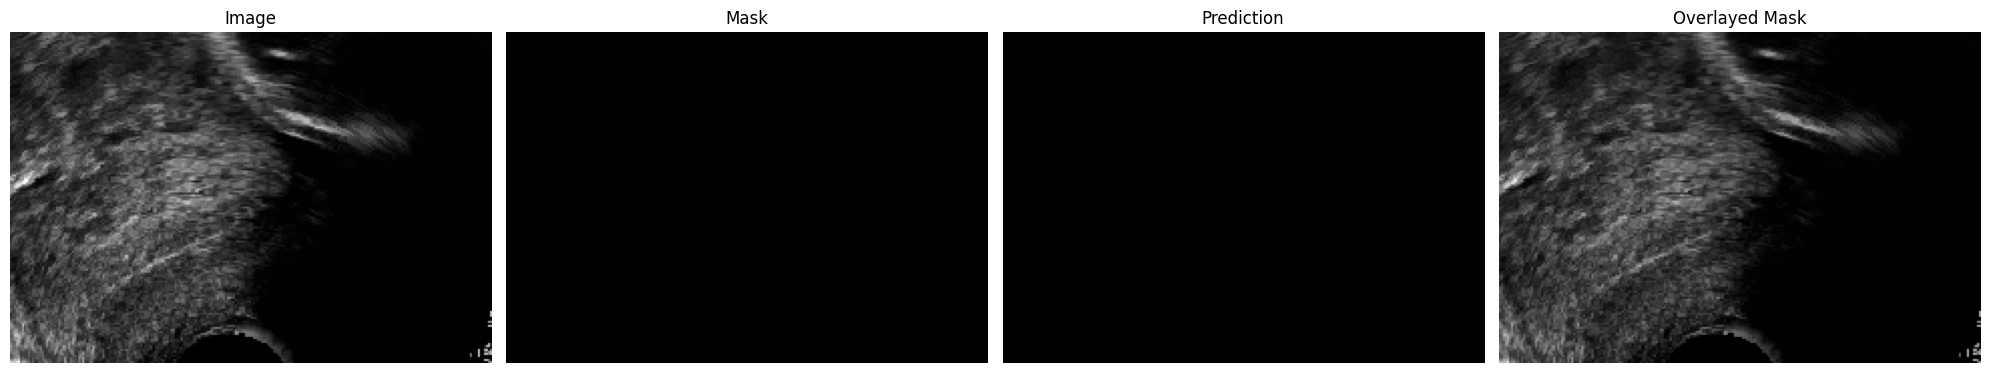

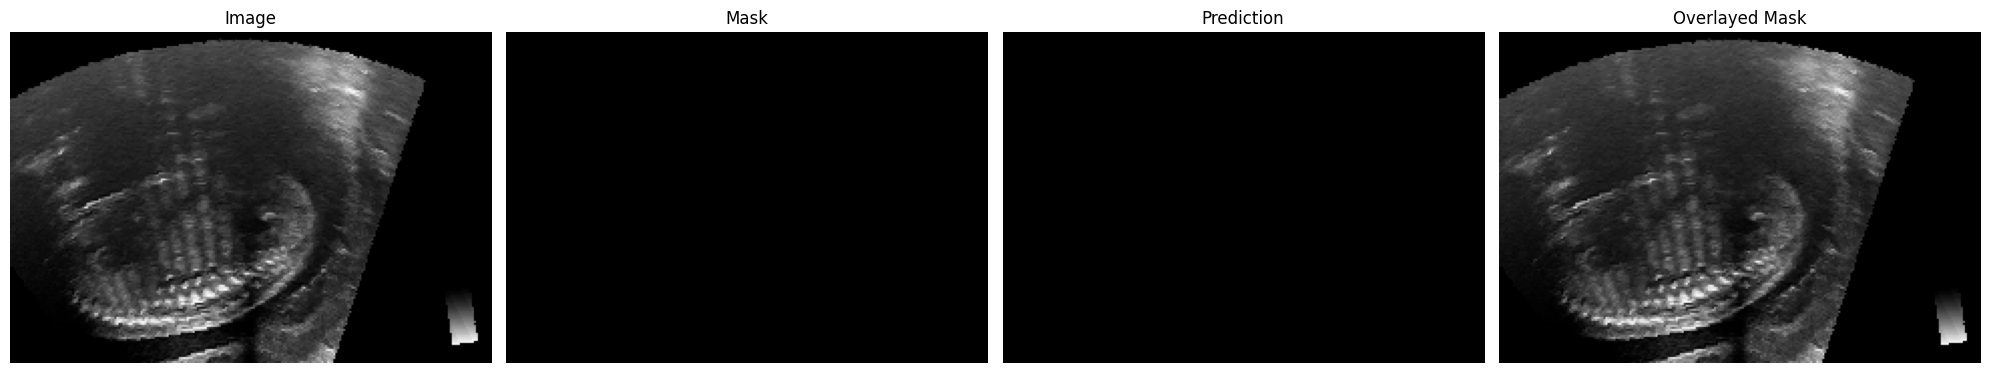

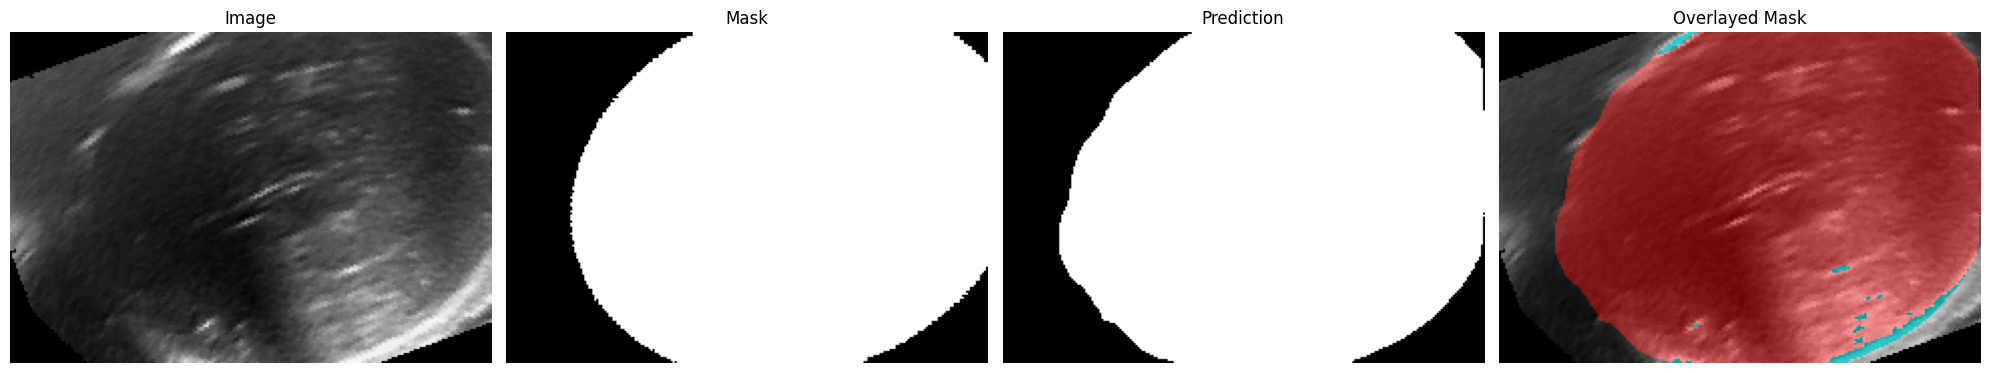

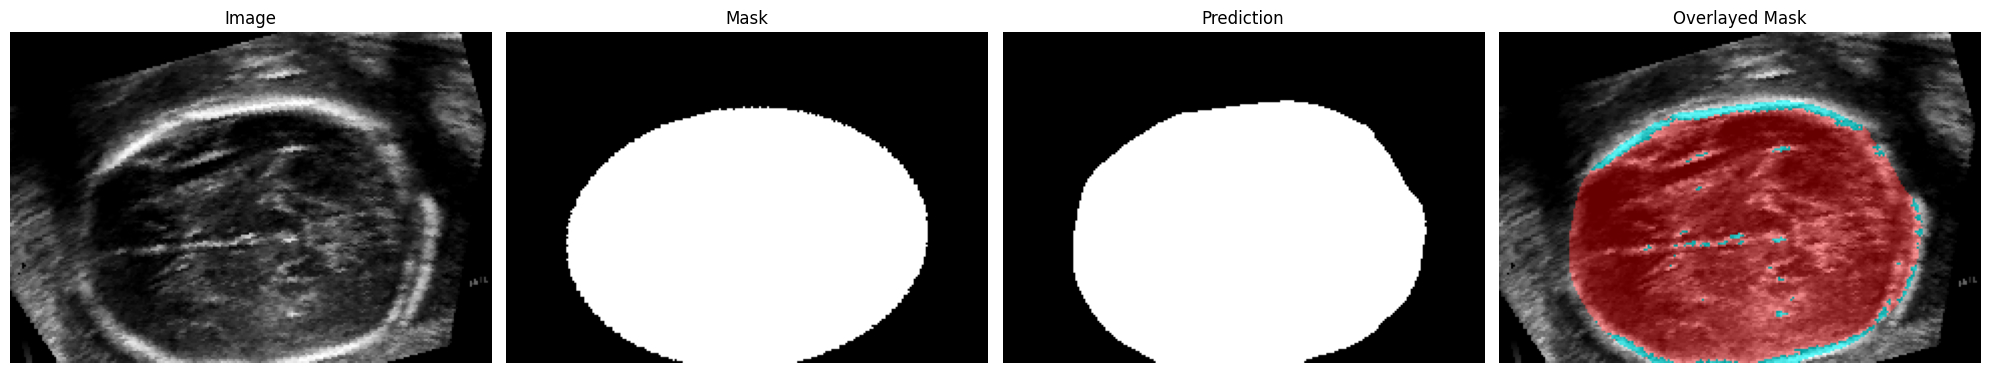

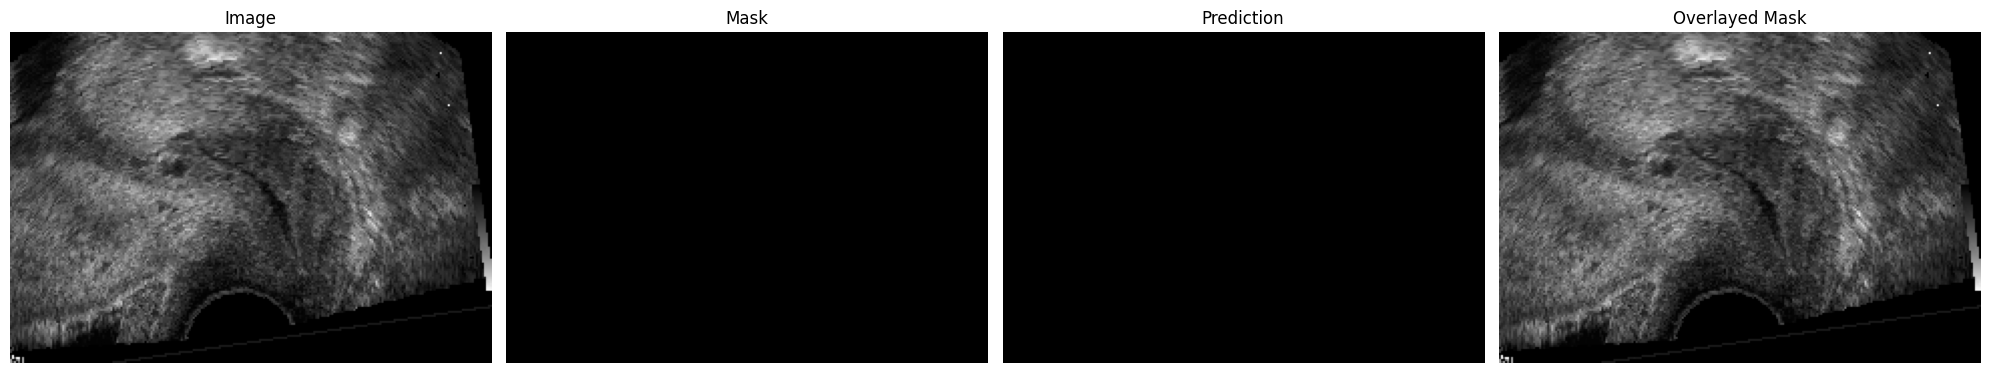

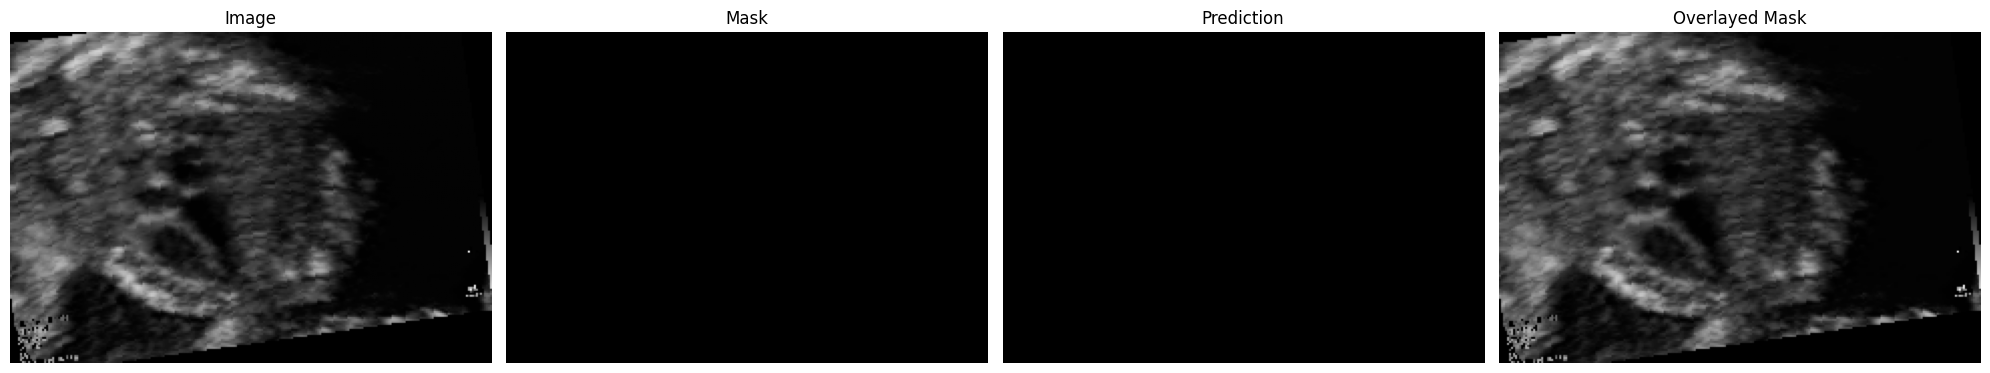

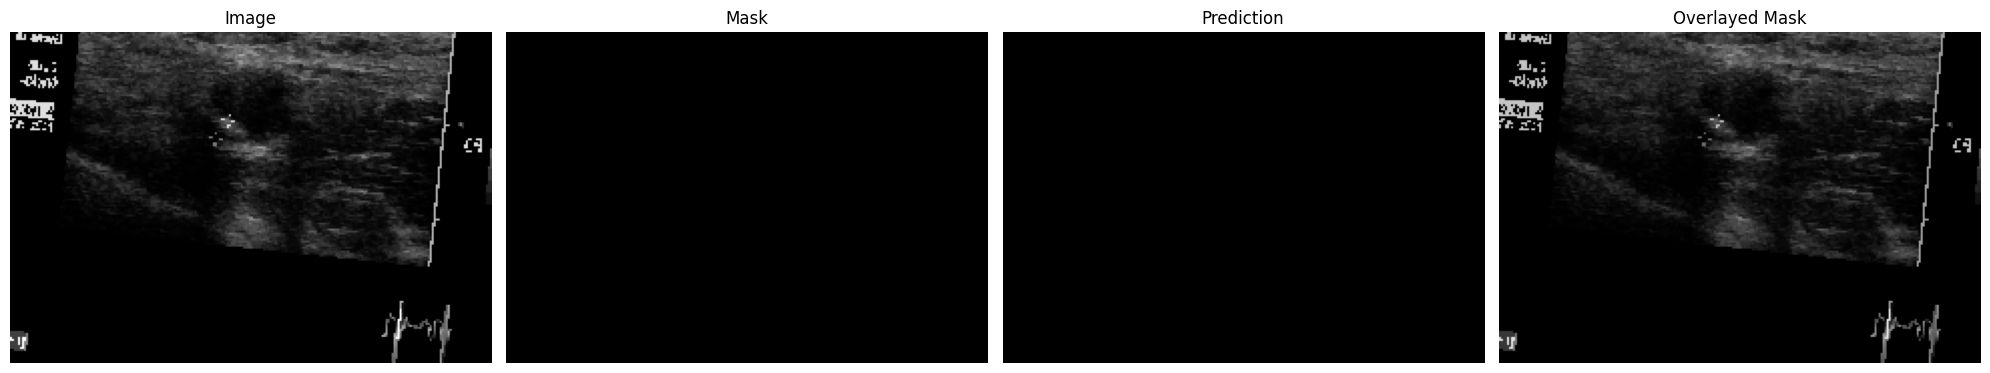

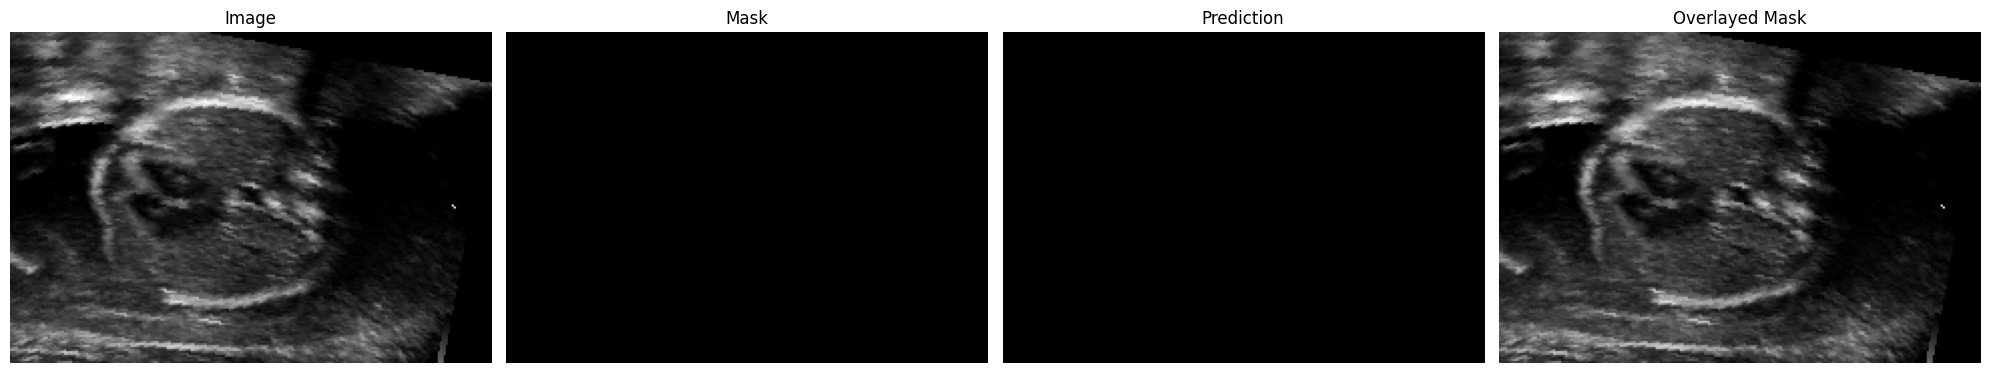

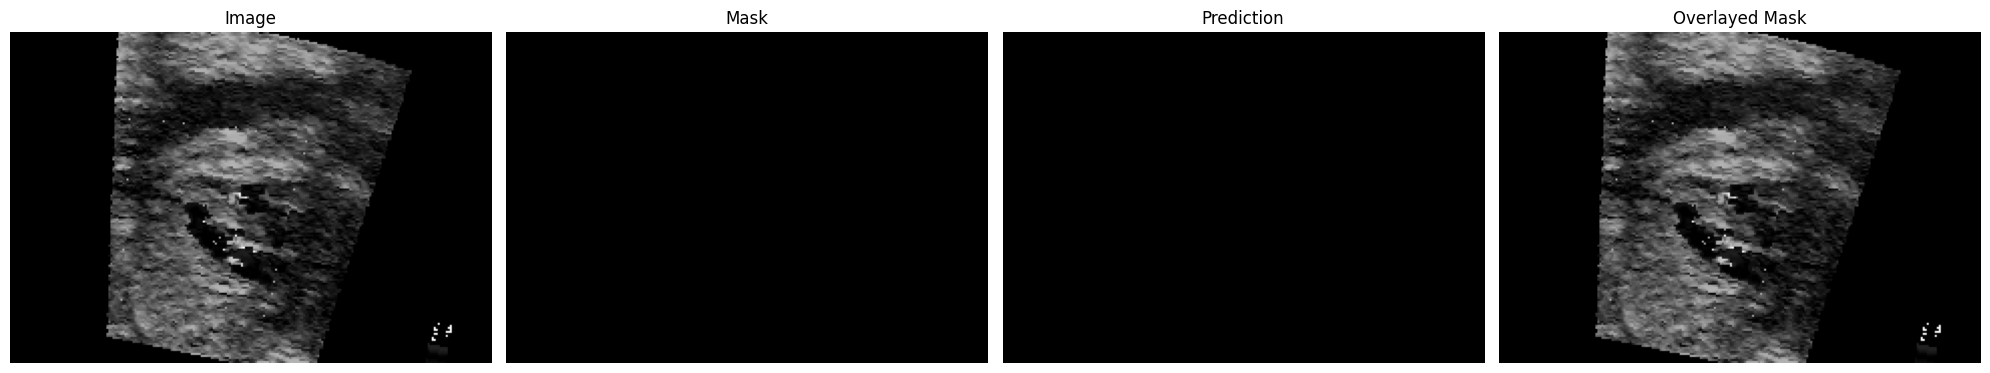

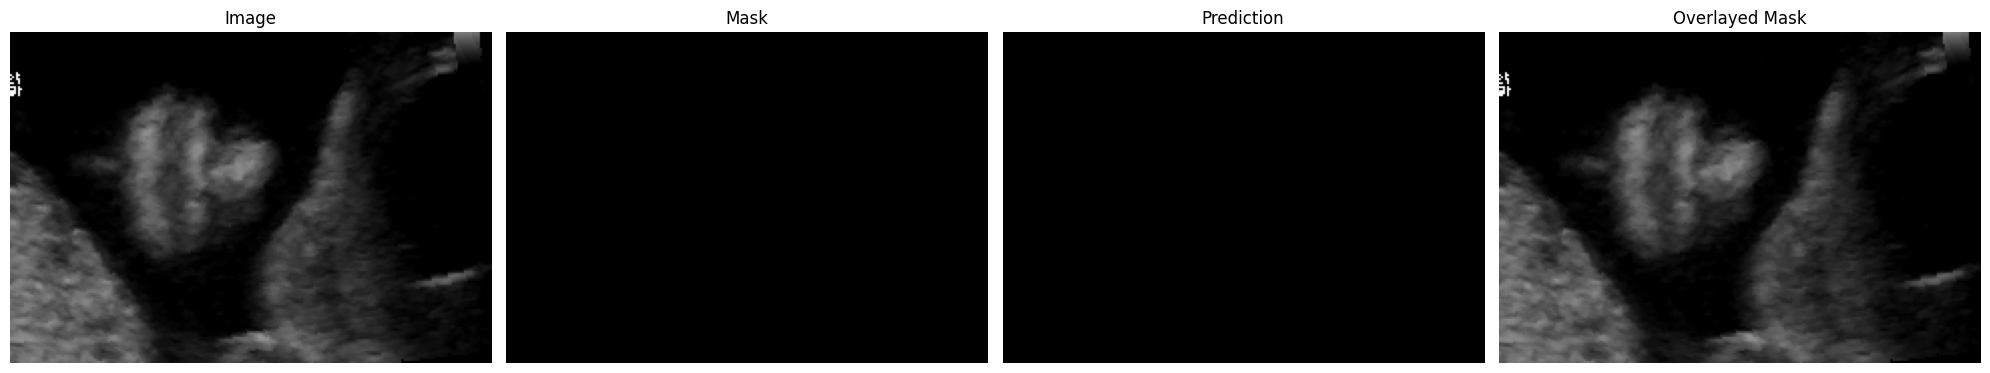

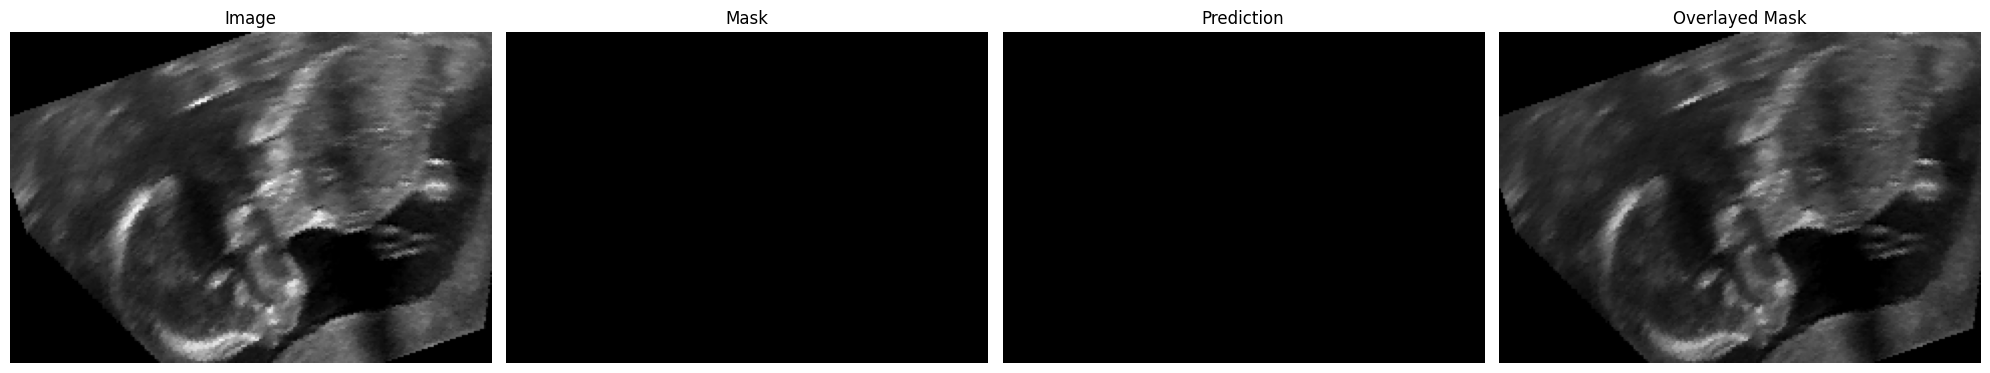

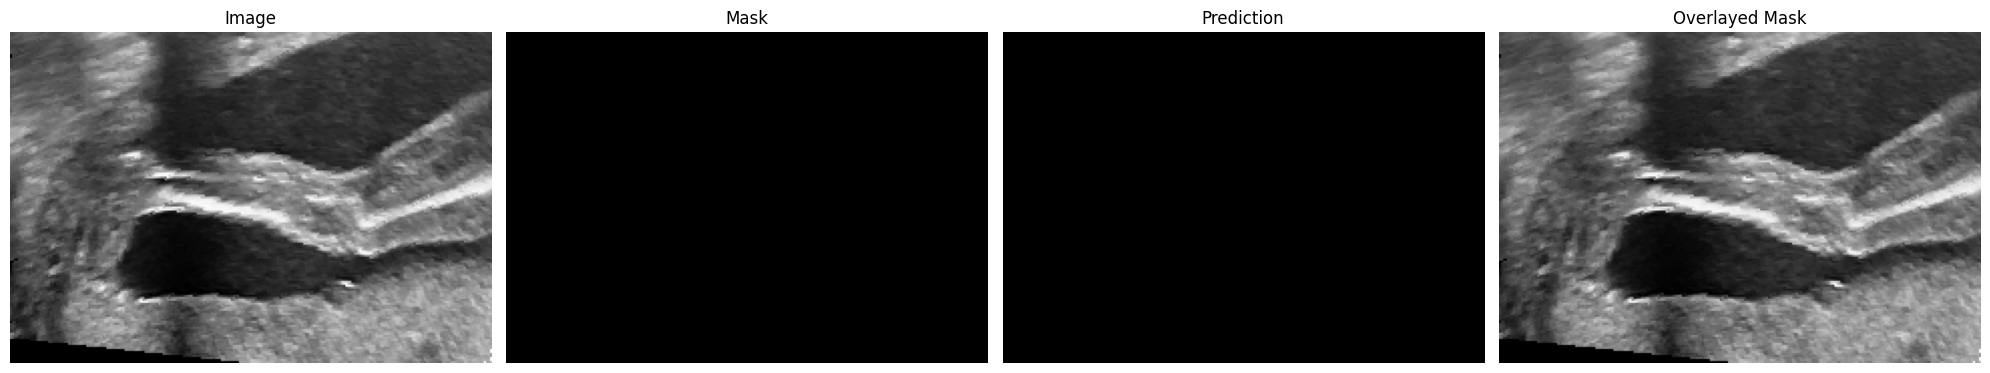

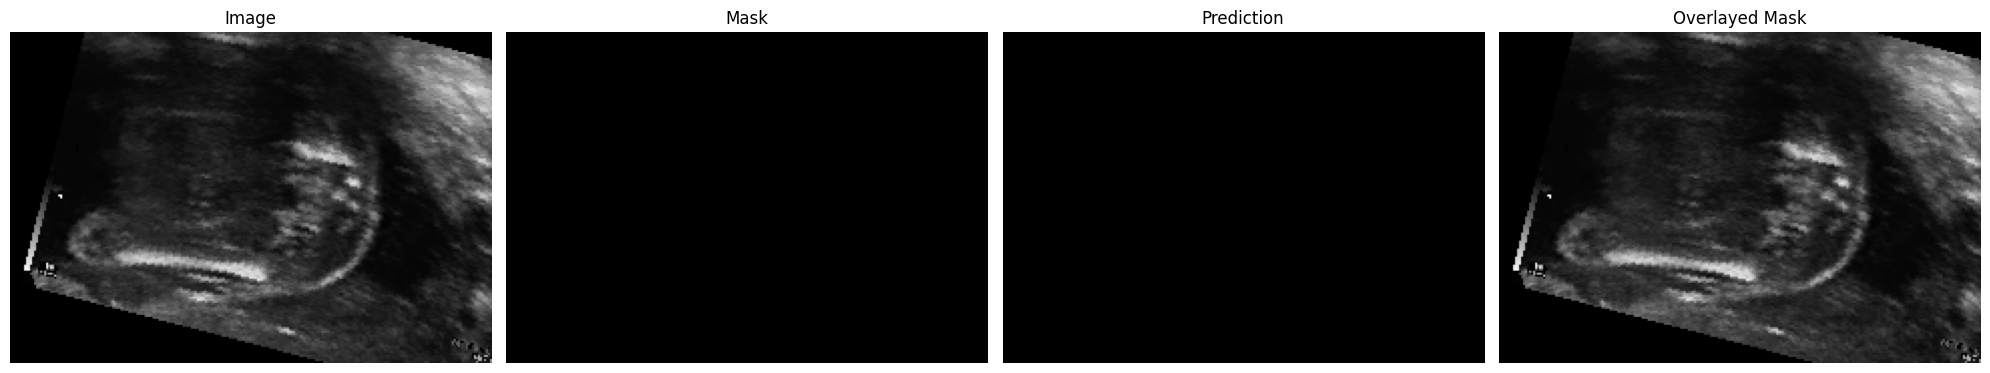

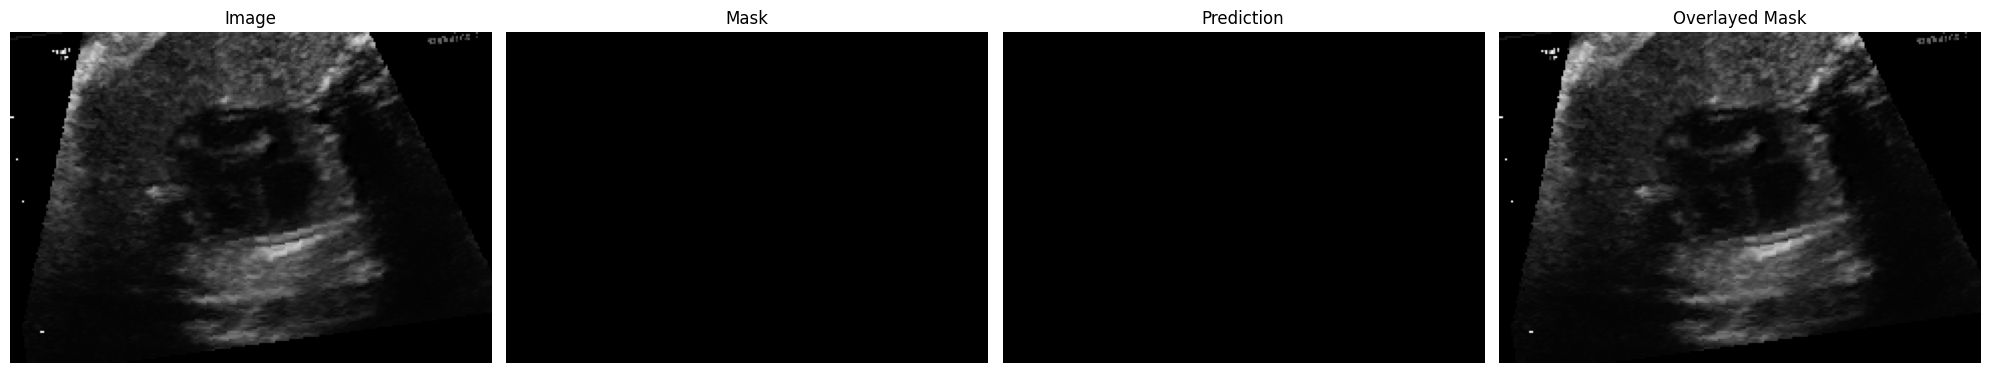

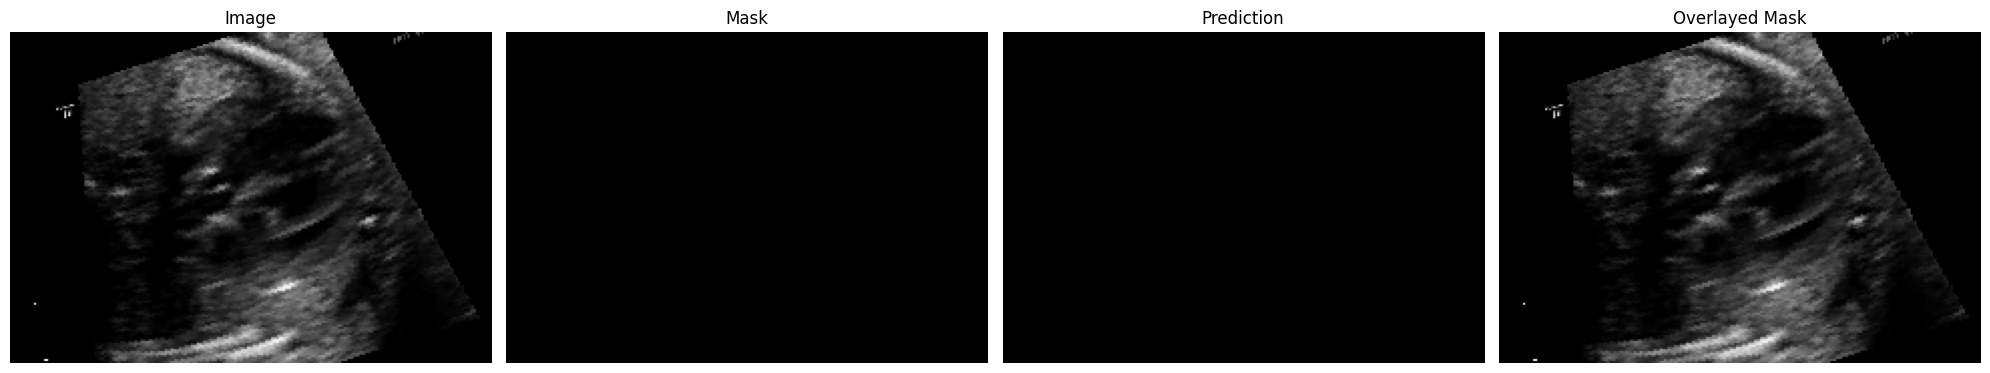

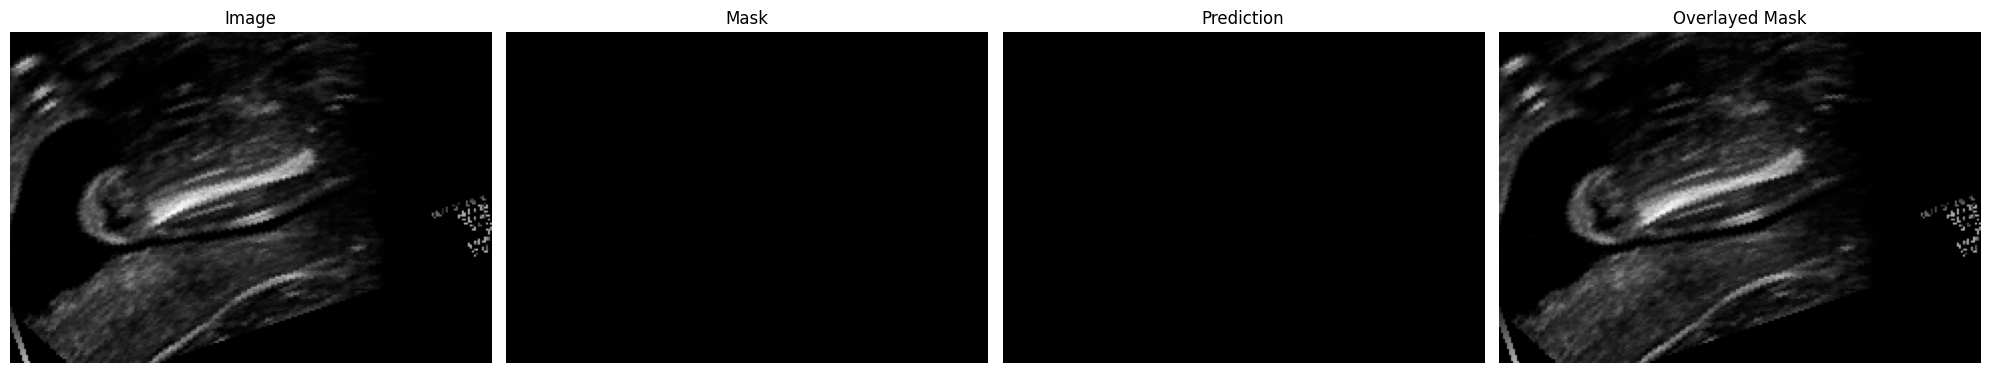

In [92]:
def display_image_mask_prediction(image, mask, prediction):
    fig, axes = plt.subplots(ncols=4, nrows=1, squeeze=False, figsize=(20, 4))
    mask = mask.float()
    display_image(image, axes[0, 0], "Image")
    display_image(mask, axes[0, 1], "Mask")
    display_image(prediction, axes[0, 2], "Prediction")
    overlap_mask(image, prediction, axes[0, 3], "Overlayed Mask")

    plt.tight_layout()
    plt.show()
 
    return

lit_module.eval()
dataset = data_module.data_train

for i in np.random.permutation(len(dataset))[:25]:
    image, mask, label = dataset[i]
    
    with torch.no_grad():
        logits = lit_module(image.unsqueeze(0)).squeeze(0)
    prediction = (torch.sigmoid(logits) > 0.5).float()
    display_image_mask_prediction(image, mask, prediction)